# Deaths by Natural Disasters and Climate Change

*Sebastian Fürndraht, Hannes Rokitte, Paul Schmitt, Lukas Wieser*

## Overview
- 1\. Introduction
    - 1.1\. Research Questions
    - 1.2\. Used Datasets
    - 1.3\. Requirements & Dependencies
    - 1.4\. Constants
    - 1.5\. Download Temperature Data
    - 1.6\. Load Raw Datasets
- 2\. Data Integration
    - 2.1\. Preprocess CIA dataset
    - 2.2\. Determine ISO codes for temperature data
    - 2.3\. Which countries are in which datasets?
    - 2.4\. Which regions are in which datasets?
    - 2.5\. Which countries need to be manually assigned a region
- 3\. Prepare Datasets
    - ...
- 4\. Data Exploration
    - ...
- 5\. Conclusion
    - ...



## 1. Introduction

In this notebook we want to explore the deaths by natural disasters, and possible relations to climate change.

### 1.1. Research Questions

- How did the number of deaths per year from natural disasters change over the last hundred years?
- How does this vary by country?
- How does this vary by type of natural disaster?
- Are there trends visible that could be due to climate change?

### 1.2. Used Datasets

**Why we choose the datasets:**

We have 3 main datasets. For disaster data we have EM-DAT. For determining the deaths per population of a natural disaster we also have the Gapminder Population Dataset. And finally for analysing trends of natural disasters with climate change we have temperature data by Berkeley Earth Study.

Additionally, we have 2 auxiliary datasets for countries (UN Country Codes and CIA Country Codes). The temperature dataset only contains country names, and these datasets help us to derive the country codes. We need both of them since the CIA dataset is a bit outdated, and the UN dataset does only contain official UN countries, e.g. it excludes Taiwan. Additionally we also use the UN Dataset to derive the region of each country.

**List of the datasets:**

- EM-DAT:
    - content: Yearly deaths by disasters
    - timespan: 1900-2022
    - countries: 235
    - source: https://public.emdat.be/
    - license: this is the only dataset, which is not allowed to be published.
- Gapminder Population:
    - content: Yearly population. Globally, by country, and by region
    - timespan: 1800-2100
    - source: https://www.gapminder.org/data/documentation/gd003/
- Berkeley Earth Study:
    - content: Monthly temperature anomalies. Globally, by country, and by region
    - timespan: 1750-2020
    - source: https://berkeleyearth.org/data/
- UN Country Codes:
    - content: Country Names, ISO Codes, and Regions.
    - countries: 250
    - source: https://unstats.un.org/unsd/methodology/m49/
- CIA Country Codes:
    - content: Country Names and Country Codes
    - countries: 278
    - source: https://www.cia.gov/the-world-factbook/references/country-data-codes/


### 1.3. Requirements & Dependencies

This project was created using Python 3.9.7.
The exact versions of the dependencies can be installed with the following command.

In [1]:
#!pip install -r requirements.txt -q

In [2]:
import urllib.parse
import requests
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

### 1.4. Constants

In [3]:
# RAW
DIS_RAW_FILE = Path('data/raw/disaster/emdat_public_2022_12_22_full.xlsx')
TEMP_RAW_FOLDER = 'data/raw/temperature/'
PATH_COUNTRIES_LAND_FOLDER = 'countries-land/'
PATH_REGIONS_LAND_FOLDER = 'regions-land/'
TEMP_GLOBAL_LAND_OCEAN_FILE = 'global-land-ocean.txt'
TEMP_RAW_COUNTRIES_LIST_FILE = "data/raw/temperature/countries-list.csv"

UN_COUNTRY_CODES_FILE = 'data/raw/country-codes/un-country-codes.csv'
CIA_COUNTRY_CODES_FILE = "data/raw/country-codes/cia-country-codes.csv"

# Preprocessed (to be deleted)
DIS_PROCESSED_FOLDER = "data/processed/disaster"
DIS_PROCESSED_ALL_FILE = Path("data/processed/disaster/disaster-all.csv")

PATH_COUNTRIES_LIST_FILE = 'temp-countries-list.csv'
COUNTRIES_LIST_FILE = "temp-countries-list.csv"

TEMP_PROCESSED_FOLDER = "data/processed/temperature/"
TEMP_PROCESSED_COUNTRIES_LIST_FILE = "data/processed/temperature/temp-countries-list.csv"

POP_PROCESSED_FOLDER = "data/processed/population"
POP_PROCESSED_GLOBAL_FILE = 'data/processed/population/population-global.csv'
POP_PROCESSED_REGION_FILE = 'data/processed/population/population-region.csv'
POP_PROCESSED_COUNTRY_FILE = 'data/processed/population/population-country.csv'

### Create Directories

In [4]:
Path(DIS_PROCESSED_FOLDER).mkdir(parents=True, exist_ok=True)
Path(TEMP_PROCESSED_FOLDER).mkdir(parents=True, exist_ok=True)
Path(POP_PROCESSED_FOLDER).mkdir(parents=True, exist_ok=True)

### Set sns theme

In [5]:
sns.set_theme()

### 1.5. Download Temperature Data
Automatically download the regional and country temperature data, so we don't have to download each file by ourselves.

In [6]:
countries = pd.read_csv(TEMP_RAW_COUNTRIES_LIST_FILE, sep=";")

In [7]:
temp_regions = countries["Region"].dropna().unique().tolist()
temp_countries = countries["Country"].tolist()

In [8]:
def download_temperature_countries(country_names: list[str]):
    for country in country_names:
        print(f"downloading {country}")
        country_encoded = urllib.parse.quote(country.lower().replace(" ", "-"),encoding='cp1252')
        url = f"http://berkeleyearth.lbl.gov/auto/Regional/TAVG/Text/{country_encoded}-TAVG-Trend.txt"
        response = requests.get(url)
        data = response.text
        with open(f'data/raw/temperature/countries-land/{country}.txt', 'w', encoding="utf-8") as file:
            file.write(data)

In [9]:
def download_temperature_regions(region_names: list[str]):
    for region in region_names:
        print(f"downloading {region}")
        region_encoded = urllib.parse.quote(region.lower().replace(" ", "-"),encoding='cp1252')
        url = f"http://berkeleyearth.lbl.gov/auto/Regional/TAVG/Text/{region_encoded}-TAVG-Trend.txt"
        response = requests.get(url)
        data = response.text
        with open(f'data/raw/temperature/regions-land/{region}.txt', 'w', encoding="utf-8") as file:
            file.write(data)

Change the variable `should_download_temperature_data` to `True`, to download the temperature data of countries & regions. (This should not be necessary, since the data should already be downloaded)

In [10]:
should_download_temperature_data = False
if should_download_temperature_data:
    download_temperature_countries(temp_countries)
    download_temperature_regions(temp_regions)

### 1.6. Load Raw Datasets

Next we load the raw datasets. With exception to the temperature dataset, since it is divided into multiple files (e.g. one file per country) and will be loaded later on.

In [11]:
dis = pd.read_excel(DIS_RAW_FILE, skiprows=6, sheet_name="emdat data")

temperature_countries = pd.read_csv("data/raw/temperature/countries-list.csv", sep=";")

pop_dict = pd.read_excel('data/raw/population/gapminder-population-v7.xlsx', sheet_name=['data-for-world-by-year', 'data-for-regions-by-year', 'data-for-countries-etc-by-year'])
pop_global_df = pop_dict.get('data-for-world-by-year')
pop_country_df = pop_dict.get('data-for-countries-etc-by-year')
pop_region_gapminder = pop_dict.get('data-for-regions-by-year')

un_country_codes = pd.read_csv(UN_COUNTRY_CODES_FILE, sep=";")
cia_country_codes = pd.read_csv(CIA_COUNTRY_CODES_FILE, sep="\t")

/Users/hrokitte/Documents/Uni/DOPP/A2/venv/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


## 2. Data Integration

In this section we want to ensure, that we can later combine our datasets without many problems.
For this we first add country codes to the temperature dataset, and then take a closer look which countries and regions occur in each dataset.

### 2.1 Preprocess CIA dataset

First do some preprocessing on the CIA dataset, since it is a bit messy as we can see below. For example different kind of country codes are stored in the same column.

In [12]:
cia_country_codes.head(3)

,Entity,GENC,ISO 3166,Stanag,Internet,Comment
0,Afghanistan,AFG,AF | AFG | 004,AFG,.af,-
1,Akrotiri,XQZ,- | - | -,-,-,-
2,Albania,ALB,AL | ALB | 008,ALB,.al,-


In [13]:
# split iso-codes in separate columns
cia_country_codes[["ISO-alpha2","ISO-alpha3","ISO-numeric"]] = cia_country_codes["ISO 3166"].str.split("|",2,expand=True)
cia_country_codes.drop(columns=["ISO 3166"], inplace=True)
# strip whitespaces from iso-codes
cia_country_codes[["ISO-alpha2","ISO-alpha3","ISO-numeric"]] = cia_country_codes[["ISO-alpha2","ISO-alpha3","ISO-numeric"]].apply(lambda x: x.str.strip())
# replace not existing iso-codes with NaN for more clarity
cia_country_codes["ISO-alpha2"].replace("-", np.nan, inplace=True)
cia_country_codes["ISO-alpha3"].replace("-", np.nan, inplace=True)
cia_country_codes["ISO-numeric"].replace("-", np.nan, inplace=True)
# show preprocessed cia data
cia_country_codes.head(3)

/var/folders/hc/r3nrs79s3bd59z2kkrc_kmrm0000gn/T/ipykernel_66033/684058679.py:2: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  cia_country_codes[["ISO-alpha2","ISO-alpha3","ISO-numeric"]] = cia_country_codes["ISO 3166"].str.split("|",2,expand=True)


,Entity,GENC,Stanag,Internet,Comment,ISO-alpha2,ISO-alpha3,ISO-numeric
0,Afghanistan,AFG,AFG,.af,-,AF,AFG,004
1,Akrotiri,XQZ,-,-,-,NaN,NaN,NaN
2,Albania,ALB,ALB,.al,-,AL,ALB,008


### 2.2 Determine ISO codes for temperature data

Next we want to add ISO codes to the temperature dataset, since the temperature dataset only contains country names. This will help us later, when we want to relate countries in the disaster dataset to countries in the temperature dataset.

#### Remove aggregated countries.

We can see, that e.g. Denmark appears twice. This issue happens multiple times, and is due to the reason that some countries are aggregates of other countries e.g. `Denmark` consists of `Denmark (Europe)` also known as `Denmark Mainland`, and `Greenland`. The bearkley earth website has a worldmap on which the country is highlighted, this helped us to better understand what each of the conflicting countries is.

In [14]:
temperature_countries.iloc[55: 55+5]

,Country,Region
55,Cyprus,Asia
56,Czech Republic,Europe
57,Denmark,North America
58,Denmark (Europe),Europe
59,Djibouti,Africa


We decided to remove the "aggregated" country. Here is a list of the aggregate countries we removed, their individual parts still exists in the dataset:
- Denmark (Denmark Mainland, Greenland)
- France (France Mainland, French Guiana, French Polynesia, French Southern and Antarctic Lands)
- Netherlands (Netherlands Mainland, Sint Maarten, Curaçao, Aruba)
- United Kingdom (United Kingdom + Oversea territories such as Montserrat, Bermuda)

In [15]:
temperature_countries_remove = pd.DataFrame({
    "Country": ["Denmark","France", "Netherlands", "United Kingdom"],
    "Region": ["North America", np.nan, "Europe", "Europe"]
})
temperature_countries_cleaned = pd.concat([temperature_countries, temperature_countries_remove]).drop_duplicates(keep=False)

#### Rename Countries & Match ISO Codes

Some countries need to be renamed so that we find the matching country-code later. After renaming the countries we can join the country codes to the temperature data.

In [16]:
new_country_names = {
    "Denmark (Europe)": "Denmark",
    "France (Europe)": "France",
    "Netherlands (Europe)": "Netherlands",
    "United Kingdom (Europe)": "United Kingdom",
    "Åland": "Åland Islands",
    "Czech Republic": "Czechia",
    "Turkey": "Türkiye",
    "Svalbard and Jan Mayen": "Svalbard and Jan Mayen Islands",
    "Cape Verde": "Cabo Verde",
    "Turks and Caicas Islands": "Turks and Caicos Islands",
    "Swaziland": "Eswatini",
    "Macedonia": "North Macedonia",
    "Côte d'Ivoire": "Côte d’Ivoire",
    "Federated States of Micronesia": "Micronesia (Federated States of)",
    "South Georgia and the South Sandwich Isla": "South Georgia and the South Sandwich Islands",
    "Bonaire, Saint Eustatius and Saba": "Bonaire, Sint Eustatius and Saba",
    "Congo (Democratic Republic of the)": "Democratic Republic of the Congo",
    "South Korea": "Korea, South",
    "North Korea": "Korea, North",
    "Palestina": "State of Palestine"
}

temperature_countries_cleaned = temperature_countries_cleaned.replace({"Country": new_country_names}, inplace=False)

# left-join cia-country-codes and un-country-codes
temperature_countries_with_iso = temperature_countries_cleaned.merge(cia_country_codes,how="left",left_on='Country', right_on='Entity')[["Country","ISO-alpha3"]]
temperature_countries_with_iso = temperature_countries_with_iso.merge(un_country_codes,how="left",left_on='Country', right_on='Country or Area')[["Country","ISO-alpha3", "ISO-alpha3 Code"]]

# fill missing cia-country codes with un-country-codes
temperature_countries_with_iso["ISO-alpha3"].fillna(temperature_countries_with_iso["ISO-alpha3 Code"], inplace=True)
temperature_countries_with_iso.drop(columns=["ISO-alpha3 Code"], inplace=True)

# show countries for which we could not find an ISO code
temperature_countries_with_iso[temperature_countries_with_iso["ISO-alpha3"].isna()]

,Country,ISO-alpha3
18,Baker Island,NaN
113,Kingman Reef,NaN
161,Palmyra Atoll,NaN


These 3 countries/areas above do not have any country codes in general, and are quite small, so we just ignore them later on.

### 2.3 Which countries are in which datasets?

Next we take a look, if the datasets all have the same countries, or if there are countries that only exist in one dataset.

#### Disaster vs. Temperature Dataset

In [17]:
berkely_iso_codes = set(temperature_countries_with_iso["ISO-alpha3"].dropna().tolist())
emdat_iso_codes = set(dis["ISO"].unique().tolist())

emdat_and_bekely = emdat_iso_codes.intersection(berkely_iso_codes)
emdat_without_berkely = emdat_iso_codes-emdat_and_bekely
berkely_without_emdat = berkely_iso_codes-emdat_and_bekely

print(f"countries in disaster & temperature dataset: {len(emdat_and_bekely)}")
print(f"countries in disaster but not temperature dataset ({len(emdat_without_berkely)}):")
print(sorted(emdat_without_berkely))
print(f"countries in temperature but not disaster dataset ({len(berkely_without_emdat)}):")
print(sorted(berkely_without_emdat))

countries in disaster & temperature dataset: 209
countries in disaster but not temperature dataset (22):
['ANT', 'AZO', 'BMU', 'BRN', 'COK', 'CSK', 'DDR', 'DFR', 'MDV', 'MHL', 'SCG', 'SHN', 'SPI', 'SSD', 'SUN', 'TKL', 'TUV', 'VUT', 'WLF', 'YMD', 'YMN', 'YUG']
countries in temperature but not disaster dataset (20):
['ABW', 'ALA', 'AND', 'ATA', 'ATF', 'BES', 'CXR', 'ESH', 'FLK', 'FRO', 'GGY', 'GRL', 'HMD', 'JEY', 'LIE', 'MCO', 'SGS', 'SJM', 'SMR', 'SPM']


The composition of countries for which we have disaster data, but no temperature data is as follows:
- Existing Countries (usually very small countries/islands):
     - `AZO` Azores Islands, `BMU` Bermuda, `BRN` Brunei Darussalam, `COK` Cook Islands (the), `MDV` Maldives, `MHL` Marshall Islands (the), `SHN` Saint Helena, Ascension and Tristan da Cunha, `SSD` South Sudan, `TKL` Tokelau, `TUV` Tuvalu, `VUT` Vanuatu, `WLF` Wallis and Futuna
- Existing Countries (but invalid country code):
    - `SPI` Canary Islands
- Former Countries:
    - `ANT` Netherlands Antilles,`CSK` Czechoslovakia,`DDR` Germany Dem Rep,`DFR` Germany Fed Rep,`SCG` Serbia Montenegro,`SUN` Soviet Union,`YMD` Yemen P Dem Rep,`YMN` Yemen Arab Rep,`YUG` Yugoslavia

#### Disaster vs Population Dataset

In [18]:
gapminder_iso_codes = set(pop_country_df["geo"].str.upper().unique())

emdat_and_gapminder = emdat_iso_codes.intersection(gapminder_iso_codes)
emdat_without_gapminder = emdat_iso_codes-emdat_and_gapminder
gapminder_without_emdat = gapminder_iso_codes-emdat_and_gapminder

print(f"countries in disaster & population dataset: {len(emdat_and_gapminder)}")
print(f"countries in disaster but not population dataset ({len(emdat_without_gapminder)}):")
print(sorted(emdat_without_gapminder))
print(f"countries in population but not disaster dataset ({len(gapminder_without_emdat)}):")
print(sorted(gapminder_without_emdat))

countries in disaster & population dataset: 191
countries in disaster but not population dataset (40):
['AIA', 'ANT', 'ASM', 'AZO', 'BLM', 'BMU', 'COK', 'CSK', 'CUW', 'CYM', 'DDR', 'DFR', 'GLP', 'GUF', 'GUM', 'IMN', 'MAC', 'MAF', 'MNP', 'MSR', 'MTQ', 'MYT', 'NCL', 'NIU', 'PRI', 'PYF', 'REU', 'SCG', 'SHN', 'SPI', 'SUN', 'SXM', 'TCA', 'TKL', 'VGB', 'VIR', 'WLF', 'YMD', 'YMN', 'YUG']
countries in population but not disaster dataset (6):
['AND', 'HOS', 'LIE', 'MCO', 'NRU', 'SMR']


The Countries for which we have disaster data, but no population data are as follows:
- Existing Countries (independent)
    - `COK` Cook Islands (the), `NIU` Niue
- Existing Countries (dependent e.g .oversea territories)
	- `AIA` Anguilla, `ASM` American Samoa, `AZO` Azores Islands, `BLM` Saint Barthélemy, `BMU` Bermuda, `CUW` Curaçao, `CYM` Cayman Islands (the), `GLP` Guadeloupe, `GUF` French Guiana, `GUM` Guam, `IMN` Isle of Man, `MAC` Macao, `MAF` Saint Martin (French Part), `MNP` Northern Mariana Islands (the), `MSR` Montserrat, `MTQ` Martinique, `MYT` Mayotte, `NCL` New Caledonia, `PRI` Puerto Rico, `PYF` French Polynesia, `REU` Réunion, `SHN` Saint Helena, Ascension and Tristan da Cunha, `SPI` Canary Islands, `SXM` Sint Maarten (Dutch part), `TCA` Turks and Caicos Islands (the), `TKL` Tokelau, `VGB` Virgin Island (British), `VIR` Virgin Island (U.S.), `WLF` Wallis and Futuna
- Former Countries
	- `ANT` Netherlands Antilles, `CSK` Czechoslovakia, `DDR` Germany Dem Rep, `DFR` Germany Fed Rep, `SCG` Serbia Montenegro, `SUN` Soviet Union, `YMD` Yemen P Dem Rep, `YMN` Yemen Arab Rep, `YUG` Yugoslavia

#### Conclusion of comparing countries

When comparing data on the country level, we should keep in mind, that (1) countries can change over time, and (2) that for some countries should only occur in one dataset and thus should probably be ignored when trying to relate disasters with climate change.

We can later also handle former countries e.g. merge `DDR` and `DFR` into `DEU`.

### 2.4 Which regions are in which datasets?

The regions have different names for each dataset ("continent", "geo", "Region").

In [19]:
dis["Continent"].unique().tolist()

['Africa', 'Asia', 'Europe', 'Americas', 'Oceania']

In [20]:
pop_region_gapminder["geo"].unique().tolist()

['africa', 'asia', 'europe', 'americas']

In [21]:
temperature_countries["Region"].dropna().unique().tolist()

['Asia', 'Europe', 'Africa', 'South America', 'Oceania', 'North America']

As we can see, each dataset has a different number of regions. Additionally, we don't know which countries belong to each region. For example the region Europe could consist of different countries the disaster dataset than in the temperature dataset.

That's why we decided to **compute the regional data ourselves**, by aggregating the countries according to UN Regions.

### 2.5 Which countries need to be manually assigned a region

Check which countries are not in the UN dataset, and thus need to be manually assigned a region.

In [22]:
un_iso_codes = set(un_country_codes["ISO-alpha3 Code"].tolist())

emdat_without_un = emdat_iso_codes-un_iso_codes
gapminder_without_un = gapminder_iso_codes-un_iso_codes
berkely_without_un = berkely_iso_codes-un_iso_codes

print(f"countries in disaster, but not UN dataset ({len(emdat_without_un)}): \n{sorted(emdat_without_un)}")
print(f"countries in population, but not UN dataset ({len(gapminder_without_un)}): \n{sorted(gapminder_without_un)}")
print(f"countries in temperature, but not UN dataset ({len(berkely_without_un)}): \n{sorted(berkely_without_un)}")

countries in disaster, but not UN dataset (12): 
['ANT', 'AZO', 'CSK', 'DDR', 'DFR', 'SCG', 'SPI', 'SUN', 'TWN', 'YMD', 'YMN', 'YUG']
countries in population, but not UN dataset (2): 
['HOS', 'TWN']
countries in temperature, but not UN dataset (1): 
['TWN']


## 3. Prepare Datasets

In this section we apply preprocessing to our 3 datasets. This includes standardizing the column names, removing unnecessary columns, removing rows, handling missing values, deriving the region of each country, aggregating data, etc.

### 3.1 Disaster Data

The goal is to preprocess the disaster data for later use.

**What is considered as a disaster?**

The publisher of the dataset *Centre for Research on the Epidemiology of Disasters* (CRED) defines a disaster as “a situation or event that overwhelms local capacity, necessitating a request at the national or international level for external assistance; an unforeseen and often sudden event that causes great damage, destruction and human suffering”

For a disaster to be entered into the database at least one of the following criteria must be fulfilled:

- 10 or more people reported killed
- 100 or more people reported affected
- Declaration of a state of emergency
- Call for international assistance

First look at the disaster data:

In [23]:
dis.head()

,Dis No,Year,Seq,Glide,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Event Name,...,"Reconstruction Costs, Adjusted ('000 US$)",Insured Damages ('000 US$),"Insured Damages, Adjusted ('000 US$)",Total Damages ('000 US$),"Total Damages, Adjusted ('000 US$)",CPI,Adm Level,Admin1 Code,Admin2 Code,Geo Locations
0,1900-9002-CPV,1900,9002,NaN,Natural,Climatological,Drought,Drought,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.077091,NaN,NaN,NaN,NaN
1,1900-9001-IND,1900,9001,NaN,Natural,Climatological,Drought,Drought,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.077091,NaN,NaN,NaN,NaN
2,1901-0003-BEL,1901,3,NaN,Technological,Technological,Industrial accident,Explosion,NaN,Coal mine,...,NaN,NaN,NaN,NaN,NaN,3.077091,NaN,NaN,NaN,NaN
3,1902-0012-GTM,1902,12,NaN,Natural,Geophysical,Earthquake,Ground movement,NaN,NaN,...,NaN,NaN,NaN,25000.0,781207.0,3.200175,NaN,NaN,NaN,NaN
4,1902-0003-GTM,1902,3,NaN,Natural,Geophysical,Volcanic activity,Ash fall,NaN,Santa Maria,...,NaN,NaN,NaN,NaN,NaN,3.200175,NaN,NaN,NaN,NaN


We can see that each row contains a single disaster, and corresponding information.

#### Select & Rename Attributes

Replace whitespaces with underscores, convert every character to lowercase, rename specific columns to ensure uniformity
and finally select only the interesting columns. Other columns like "economic" impact are removed, since they are out of scope for this task.

In [24]:
# Remove whitespaces from all col-names and convert them to lower-case
dis.columns = [c.replace(' ', '_').lower() for c in dis.columns]
dis.rename(columns={'country':'country_name', 'iso':'country_code', 'disaster_group':'group','disaster_subgroup':'subgroup', 'disaster_subtype':'subtype', 'disaster_type':'type', 'total_deaths':'deaths'}, inplace=True)

In [25]:
# Select the most interesting columns
dis_all_col_names = ["year", "dis_no", "country_name", "country_code", "location","group","subgroup", "type", "subtype", "deaths", "dis_mag_value", "dis_mag_scale", "start_year", "end_year"]
dis_all = dis.filter(items=dis_all_col_names)

#### Which disaster groups are present in the dataset ?

There are Natural disasters, technological disasters as well as complex disasters that represent specific events (e.g. famine) which are not directly linked to a natural hazard.

In [26]:
dis_all["group"].unique().tolist()

['Natural', 'Technological', 'Complex Disasters']

We only focus on disasters which have a natural causation

In [27]:
dis_all = dis_all[dis_all["group"] == "Natural"].copy()
dis_all.drop(columns="group", inplace=True)

Which types of natural disasters are there ?

In [28]:
dis_all.groupby(["subgroup","type"]).agg({"deaths":"sum"}).reset_index()

,subgroup,type,deaths
0,Biological,Animal accident,12.0
1,Biological,Epidemic,9618804.0
2,Biological,Insect infestation,0.0
3,Climatological,Drought,11733889.0
4,Climatological,Glacial lake outburst,262.0
5,Climatological,Wildfire,4653.0
6,Extra-terrestrial,Impact,0.0
7,Geophysical,Earthquake,2343912.0
8,Geophysical,Mass movement (dry),4644.0
9,Geophysical,Volcanic activity,86893.0


The types of disasters are mostly the ones a normal person would expect when thinking about natural disasters. But there are some strange types like `Insect Infestations` or `Animal Accident` which are not that obvious to understand, they also have basically no deaths. Also, for our research we want to exclude `Epidemics` since it would go beyond the scope of this task.

Therefore also decided to omit disasters of the subgroups `Biological` and `Extra-terrestrial`.

In [29]:
dis_all = dis_all[(dis_all["subgroup"] != "Biological") & (dis_all["subgroup"] != "Extra-terrestrial")]

We only consider the following types of disasters:

In [30]:
sorted(dis_all["type"].unique())

['Drought',
 'Earthquake',
 'Extreme temperature ',
 'Flood',
 'Fog',
 'Glacial lake outburst',
 'Landslide',
 'Mass movement (dry)',
 'Storm',
 'Volcanic activity',
 'Wildfire']

#### Handle Missing Values

Fill missing Values for the number of deaths

We can assume that missing values for the number of deaths of a particular disaster means that the deathtoll was 0.

For the subtype we take a look for which type of natural disasters a subtype is not provided.

In [31]:
dis_all.isna().sum()

year                0
dis_no              0
country_name        0
country_code        0
location         1449
subgroup            0
type                0
subtype          3116
deaths           4412
dis_mag_value    9903
dis_mag_scale    1114
start_year          0
end_year            0
dtype: int64

We can see that all disasters have a year, country, and type. However, especially for subtype and deaths it would be interesting to take a closer look, since the "type" of disasters and the "deaths" are integral parts of our analysis.

In [32]:
sorted(dis_all[dis_all["subtype"].isna()]["type"].unique())

['Drought',
 'Earthquake',
 'Flood',
 'Fog',
 'Glacial lake outburst',
 'Landslide',
 'Mass movement (dry)',
 'Storm',
 'Volcanic activity',
 'Wildfire']

Unfortunately the missing values in the subtype column do not correspond to specific types of disasters, but basically all diaster types have missing subtypes. We can not conclude that easily what caused the values to be missing.

In [33]:
dis_all[dis_all["type"] == "Drought"].subtype.unique()

array(['Drought', nan], dtype=object)

Disasters of type drought have no further more specific subtype. Consequently, we assign all droughts with missing values for subtype, the general type

In [34]:
dis_all.loc[dis_all["type"] == "Drought", "subtype"] = dis_all.loc[dis_all["type"] == "Drought", "subtype"].fillna("Drought")

For all other types, we unfortunately can not guess the subtype. Therefore, we assign a custom label "Uncategorized" + the type of the disaster for each missing subtype. We do not need to do this for disasters of type extreme temperature, since subtypes for all observations are specified

In [35]:
dis_all.loc[dis_all["type"] == "Earthquake", "subtype"] = dis_all.loc[dis_all["type"] == "Earthquake", "subtype"].fillna("Uncategorized_Earthquake")
dis_all.loc[dis_all["type"] == "Storm", "subtype"] = dis_all.loc[dis_all["type"] == "Storm", "subtype"].fillna("Uncategorized_Storm")
dis_all.loc[dis_all["type"] == "Flood", "subtype"] = dis_all.loc[dis_all["type"] == "Flood", "subtype"].fillna("Uncategorized_Flood")

We assume that disasters with no death toll reported have a death toll of 0. This also aligns with the information we get from the source of our dataset (deaths tolls smaller than 10 are not registered)

In [36]:
dis_all[['deaths']] = dis_all[['deaths']].fillna(value=0)

#### Determine Regions

As mentioned in `data integration` we want to compute the region of each disaster, by taking the UN Region that is assigned to each Country, in which the disaster occurred. Some country codes are not in the list of UN countries, thus we handle them specifically later.

Once more, here are the countries that need to be handled specifically:

In [37]:
dis_iso_codes = set(dis_all["country_code"].unique())
un_iso_codes = set(un_country_codes["ISO-alpha3 Code"].tolist())
emdat_without_un = dis_iso_codes-un_iso_codes
print(f"countries in disaster, but not un dataset ({len(emdat_without_un)}): \n{sorted(emdat_without_un)}")

countries in disaster, but not un dataset (12): 
['ANT', 'AZO', 'CSK', 'DDR', 'DFR', 'SCG', 'SPI', 'SUN', 'TWN', 'YMD', 'YMN', 'YUG']


**Automatically assign regions with UN Dataset**

For countries that were split in the past, but are now unified, we can just assign the unified country.

In [38]:
# Germany
dis_all.loc[dis_all['country_code'] == "DFR",'country_code'] = "DEU"
dis_all.loc[dis_all['country_code'] == "DDR",'country_code'] = "DEU"
# Yemen
dis_all.loc[dis_all['country_code'] == "YMD",'country_code'] = "YEM"
dis_all.loc[dis_all['country_code'] == "YMN",'country_code'] = "YEM"

Next we derive the region by using the UN dataset.

In [39]:
dis_all = pd.merge(dis_all, un_country_codes[["ISO-alpha3 Code","Region Name", "Region Code"]], left_on='country_code', right_on='ISO-alpha3 Code', how='left')
dis_all.rename(columns={"Region Code": "region_code", "Region Name": "region_name"}, inplace=True)
dis_all.drop(columns=["ISO-alpha3 Code"],inplace=True)

**Manually Assign Regions**

Some countries clearly belong to one region, so we can assign the disasters manually

In [40]:
# Taiwan
dis_all.loc[dis_all['country_code']=='TWN','region_name'] = 'Asia'
dis_all.loc[dis_all['country_code']=='TWN','region_code'] = 142
# Czechoslovakia
dis_all.loc[dis_all['country_code']=='CSK','region_name'] = 'Europe'
dis_all.loc[dis_all['country_code']=='CSK','region_code'] = 150
# Yugoslavia
dis_all.loc[dis_all['country_code']=='YUG','region_name'] = 'Europe'
dis_all.loc[dis_all['country_code']=='YUG','region_code'] = 150
# Serbia Montenegro
dis_all.loc[dis_all['country_code']=='SCG','region_name'] = 'Europe'
dis_all.loc[dis_all['country_code']=='SCG','region_code'] = 150
# Netherlands Antilles
dis_all.loc[dis_all['country_code']=='ANT','region_name'] = 'Americas'
dis_all.loc[dis_all['country_code']=='ANT','region_code'] = 19
# Azores Islands
dis_all.loc[dis_all['country_code']=='AZO','region_name'] = 'Europe'
dis_all.loc[dis_all['country_code']=='AZO','region_code'] = 150
# Canary Islands
dis_all.loc[dis_all['country_code']=='SPI','region_name'] = 'Europe'
dis_all.loc[dis_all['country_code']=='SPI','region_code'] = 150

**Manually Assign Regions of Soviet Union**

For the Soviet Union disasters can occur in the european and/or asian parts. Thus we also take the "location" attribute into account and try to derive if the disaster was in europe or asia.

In [41]:
mask_europe = dis_all.loc[dis_all['country_code']=='SUN']["location"].str.contains("Russian Federation|Ukraine|Moldavia|Siberia").fillna(False)
mask_asia = dis_all.loc[dis_all['country_code']=='SUN']["location"].str.contains("Kazakhstan|Azerbaijan|Uzbekistan|Turkmenistan|Georgia|Armenia|Kyrgystan|Tajikistan|Tajiskistan|Tadzhikistan|Tadjikistan|Caucasus region|Dushanbe", case=False).fillna(False)

In [42]:
dis_all[dis_all['country_code']=='SUN'][mask_europe & mask_asia]

,year,dis_no,country_name,country_code,location,subgroup,type,subtype,deaths,dis_mag_value,dis_mag_scale,start_year,end_year,region_name,region_code
849,1921,1921-9001-SUN,Soviet Union,SUN,"South Ukraine, Volga, Ural (Kazakhstan,Russian...",Climatological,Drought,Drought,1200000.0,NaN,Km2,1921,1921,NaN,NaN


Only one Event happened in both the asian and the european part of the soviet union. It is also a major event since it is a drought which caused the death of 1.2 million people.

Researching the details of this event one can conclude that this observation can only be the [Russian famine of 1921–1922](https://en.wikipedia.org/wiki/Russian_famine_of_1921%E2%80%931922). It mostly affected people living in europe, hence we assign this single observation the region europe.

For all other observations, the region should be unambiguous.

In [43]:
dis_all.loc[(dis_all['country_code']=='SUN') & mask_europe, "region_name"] = "Europe"
dis_all.loc[(dis_all['country_code']=='SUN') & mask_europe, "region_code"] = 150

dis_all.loc[(dis_all['country_code']=='SUN') & mask_asia, "region_name"] = "Asia"
dis_all.loc[(dis_all['country_code']=='SUN') & mask_asia, "region_code"] = 142

dis_all.loc[dis_all['dis_no']=='1921-9001-SUN', "region_name"] = "Europe"
dis_all.loc[dis_all['dis_no']=='1921-9001-SUN', "region_code"] = 150

The only disasters without a region are now these 3 in the soviet Union. However, since they have no death count and are just 3 disaster, we can safely ignore them.

In [44]:
dis_all[dis_all["region_code"].isna()]

,year,dis_no,country_name,country_code,location,subgroup,type,subtype,deaths,dis_mag_value,dis_mag_scale,start_year,end_year,region_name,region_code
3187,1981,1981-0280-SUN,Soviet Union,SUN,East,Meteorological,Storm,Uncategorized_Storm,0.0,NaN,Kph,1981,1981,NaN,NaN
3188,1981,1981-0301-SUN,Soviet Union,SUN,NaN,Hydrological,Flood,Uncategorized_Flood,0.0,NaN,Km2,1981,1981,NaN,NaN
3213,1982,1982-0346-SUN,Soviet Union,SUN,East,Hydrological,Flood,Uncategorized_Flood,0.0,150.0,Km2,1982,1982,NaN,NaN


We remove White-Spaces from type as well as subtype for more convenience

In [45]:
dis_all["type"] = dis_all["type"].apply(lambda x: x.replace(" ", "_") if x[-1] != ' ' else x.replace(" ", "_"))
dis_all['subtype'].replace(" ", "_", inplace=True, regex=True)
dis_all["type"] = dis_all["type"].apply(lambda x: x.rstrip("_"))

##### Deal with missing values for attribute subtype for our selected disaster types

In [46]:
dis_all.loc[dis_all["type"] == "Drought", "subtype"] = dis_all.loc[dis_all["type"] == "Drought", "subtype"].fillna("Drought")


For all other types, we unfortunately can not guess the subtype. Therefore, we assign a custom label “Uncategorized” + the type of the disaster for each missing subtype We do not need to do this for disasters of type extreme temperature, since subtypes for all observations are specified

In [47]:
dis_all.loc[dis_all["type"] == "Earthquake", "subtype"] = dis_all.loc[dis_all["type"] == "Earthquake", "subtype"].fillna("Uncategorized_Earthquake")
dis_all.loc[dis_all["type"] == "Storm", "subtype"] = dis_all.loc[dis_all["type"] == "Storm", "subtype"].fillna("Uncategorized_Storm")
dis_all.loc[dis_all["type"] == "Flood", "subtype"] = dis_all.loc[dis_all["type"] == "Flood", "subtype"].fillna("Uncategorized_Flood")

#### Look at the preprocessed data

The preprocessed disaster data now looks like this:

In [48]:
# Todo: Remove later
dis_all.to_csv(DIS_PROCESSED_ALL_FILE, index=False)

In [49]:
dis_all.head(3)

,year,dis_no,country_name,country_code,location,subgroup,type,subtype,deaths,dis_mag_value,dis_mag_scale,start_year,end_year,region_name,region_code
0,1900,1900-9002-CPV,Cabo Verde,CPV,Countrywide,Climatological,Drought,Drought,11000.0,NaN,Km2,1900,1900,Africa,2.0
1,1900,1900-9001-IND,India,IND,Bengal,Climatological,Drought,Drought,1250000.0,NaN,Km2,1900,1900,Asia,142.0
2,1902,1902-0012-GTM,Guatemala,GTM,"Quezaltenango, San Marcos",Geophysical,Earthquake,Ground_movement,2000.0,8.0,Richter,1902,1902,Americas,19.0


### 3.2 Population Data

The goal is to preprocess the population dataset. Specifically we want to create 3 datasets, one for the global level, one for the regional level, and one for the country level.

We consider the period from 1900 until 2021 and remove redundant rows. We do this because the data after 2021 are based on estimated values, and are basically predictions into the future.

Since the regions of the dataset did not match with the regions of our other datasets, we chose to compute the regions-population according to the regions from the un-country-codes.csv file.

**How exactly is the population determined?**
The primary data from the sources originates from census, informal census, indirect estimate and arbitrary guesses.
For the years 1800-1950 the underlying data comes from the `Angus Maddison` dataset, and from 1950 onwards the data is provided by the World Population Prospects (WPP) by the UN. Therefore, we suspect that the data from 1950 onwards is more reliable, since it was collected in a more standardized manner by the UN.


#### Check for missing values

In [50]:
pop_global_df.isna().sum()

geo           0
name          0
time          0
Population    0
dtype: int64

In [51]:
pop_country_df.isna().sum()

geo             0
name            0
time            0
Population    100
dtype: int64

In [52]:
pop_country_df[pop_country_df["Population"].isna()]["geo"].unique()

array(['hos'], dtype=object)

We see that only `Holy Sea` has missing values, we will keep this in mind, and come back later.

Does the regional data have missing values?

In [53]:
pop_region_gapminder.isna().sum()

geo           0
name          0
time          0
Population    0
dtype: int64

#### Preprocess global data

In [54]:
pop_global_df.head(3)

,geo,name,time,Population
0,world,world,1800,985083734.9
1,world,world,1801,988518009.0
2,world,world,1802,991993182.0


Remove & rename columns

In [55]:
pop_global_df = pop_global_df[['time', 'Population']]
pop_global_df.rename(columns={'Population': 'population', 'time': 'year'}, inplace=True)
pop_global_df.set_index('year')

/var/folders/hc/r3nrs79s3bd59z2kkrc_kmrm0000gn/T/ipykernel_66033/2888982890.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop_global_df.rename(columns={'Population': 'population', 'time': 'year'}, inplace=True)


,population
year,
1800,9.850837e+08
1801,9.885180e+08
1802,9.919932e+08
1803,9.955096e+08
1804,9.990675e+08
...,...
2096,1.038852e+10
2097,1.037989e+10
2098,1.037045e+10


Extract population data from 1900 until 2021

In [56]:
pop_global_df = pop_global_df[pop_global_df['year'] >= 1900]
pop_global_df = pop_global_df[pop_global_df['year'] <= 2021]
pop_global_df['population'] = pop_global_df['population'].astype(int)

In [57]:
pop_global_df.head()

,year,population
100,1900,1627123965
101,1901,1639684222
102,1902,1652898195
103,1903,1666760587
104,1904,1680799825


#### Prepare dataset for countries and regions

Extract population data from 1900 until 2021

In [58]:
pop_country_df = pop_country_df[pop_country_df['time'] >= 1900]
pop_country_df = pop_country_df[pop_country_df['time'] <= 2021]

Derive the region of each country by using the UN dataset.

In [59]:
un_country_codes = un_country_codes[['Region Code', 'Region Name', 'ISO-alpha3 Code']]

# format column that will be joined
pop_country_df['geo'] = pop_country_df['geo'].str.upper()

# merge country-population and un-country-codes
pop_country_region_df = pd.merge(pop_country_df, un_country_codes, how='left', left_on='geo', right_on='ISO-alpha3 Code')
pop_country_region_df.rename(columns={'Region Code': 'region_code', 'Region Name': 'region_name', 'time': 'year', 'Population': 'population', 'geo': 'country_code', 'name': 'country_name'}, inplace=True)

# remove unused column 'ISO-alpha3 Code'
pop_country_region_df.drop('ISO-alpha3 Code', axis=1, inplace=True)

Manually add the region to the countries which are not included in the UN dataset

In [60]:
# holy see
pop_country_region_df.loc[pop_country_region_df['country_code'] == 'HOS', 'region_code'] = 150
pop_country_region_df.loc[pop_country_region_df['country_code'] == 'HOS', 'region_name'] = 'Europe'
# taiwan
pop_country_region_df.loc[pop_country_region_df['country_code'] == 'TWN', 'region_code'] = 142
pop_country_region_df.loc[pop_country_region_df['country_code'] == 'TWN', 'region_name'] = 'Asia'

Check if we worked correctly

In [61]:
pop_country_region_df["country_code"].isna().sum()

0

However `holy see` still has missing values as we saw earlier.

In [62]:
pop_country_region_df[pop_country_region_df["country_code"]=="HOS"]["population"].max()

911.0

The remaining missing values are population data for the country 'holy see' since the missing population is at maximum smaller than 1000 decided to exclude holy see from our analysis. Having no missing values helps us later, since can convert the datatype of the columns from float to integers.

In [63]:
pop_country_region_df = pop_country_region_df[pop_country_region_df["country_code"] != "HOS"]

#### Adjust Datatypes

In [64]:
pop_country_region_df["population"] = pop_country_region_df["population"].astype(np.int64)
pop_country_region_df["year"] = pop_country_region_df["year"].astype(int)

pop_global_df["year"] = pop_global_df["year"].astype(int)

pop_region_gapminder["Population"] = pop_region_gapminder["Population"].astype(np.int64)
pop_region_gapminder["time"] = pop_region_gapminder["time"].astype(int)

#### Derive regional & country data

In [65]:
columns_regions = ['region_code', 'region_name', 'country_code', 'country_name', 'year', 'population']
pop_regions_df = pop_country_region_df[columns_regions]
pop_regions_df = pop_regions_df.groupby(['region_code', 'region_name', 'year'], as_index=False)['population'].sum()
#pop_regions_df['population'] = pop_regions_df['population'].astype(np.int64)
asia = pop_regions_df[pop_regions_df['region_name'] == 'Asia']

In [66]:
columns_country = ['country_code', 'country_name', 'year', 'population']
pop_country_df = pop_country_region_df[columns_country]

#### Compare our calculated regional data to the gapminder

To check if we aggregated our regional data correctly from the country data, we comapre it to the data from original regional data from gapminder.

In [67]:
regions_population_2021_gapminder = pop_region_gapminder[pop_region_gapminder['time'] == 2021]
total_population_gapminder = regions_population_2021_gapminder['Population'].sum()

regions_population_2021_calc = pop_regions_df[pop_regions_df['year'] == 2021]
total_population_calc = regions_population_2021_calc['population'].sum()

Total population from the year 2021

In [68]:
print(f'Gapminder:  {total_population_gapminder:.0f}')
print(f'Calculated: {total_population_calc:.0f}')

Gapminder:  7898737625
Calculated: 7898737625


Gapminder population by region for 2021:

In [69]:
regions_population_2021_gapminder[['name', 'Population']]

,name,Population
221,africa,1391823318
522,asia,4634610444
823,europe,846050284
1124,americas,1026253579


Our population by region for 2021:

In [70]:
regions_population_2021_calc[['region_name', 'population']]

,region_name,population
121,Africa,1391823318
243,Oceania,43602426
365,Americas,1026253579
487,Asia,4693889556
609,Europe,743168746


As we can see, we get the same results for the total populations in the year 2021.

If we take a look at the region population, we see that the calculated population of america and africa shows no difference to the gapminder-dataset population. For the regions asia and europe, we get different results. Furthermore, the calculated region oceania does not exist in the gapminder dataset. Since the documentation of the gapminder dataset does not include the country-to-region assignment, we cannot compare the differences between our calculation and gapminder. However, since the overall score is equal, we can argue that those differences occur tue to different country-to-region assignments.

In [71]:
# Todo: Remove later
pop_global_df.to_csv(POP_PROCESSED_GLOBAL_FILE, sep=';', index=False, header=True)
#store in csv file
pop_country_df.to_csv(POP_PROCESSED_COUNTRY_FILE, sep=';', index=False, header=True)
#store in csv file
pop_regions_df.to_csv(POP_PROCESSED_REGION_FILE, sep=';', index=False, header=True)

#### Look at the preprocessed data

In [72]:
pop_global_df.head(3)

,year,population
100,1900,1627123965
101,1901,1639684222
102,1902,1652898195


In [73]:
pop_country_df.head(3)

,country_code,country_name,year,population
0,AFG,Afghanistan,1900,4707744
1,AFG,Afghanistan,1901,4751177
2,AFG,Afghanistan,1902,4802500


In [74]:
pop_regions_df.head(3)

,region_code,region_name,year,population
0,2.0,Africa,1900,138578556
1,2.0,Africa,1901,139018147
2,2.0,Africa,1902,139489077


### 3.3 Temperature Data

The goal is to preprocess the temperature dataset. Specifically we want to create 3 datasets, one for the global level, one for the regional level, and one for the country level.

Since the regions of the dataset did not match with the regions of our other datasets, we chose to derive the regions ourselves according to the UN dataset.

We also need to do combine multiple files, since the data for each country and each region is located in a desperate file.

Additionally, we aggregate the data by the year, since the other datasets also operate on a yearly basis.

#### Load country level data

In this section we load Berkleys land-temperature data for each country from the corresponding .txt files and combine them into a single dataframe. We also change the naming of the countries according to the naming standard of the UN and add their country code.

In [75]:
temp_countries = temperature_countries_with_iso

In [76]:
# manually define the column names, since the raw data unfortunately no easy way to retrieve this information.
temp_land_country_column_names = ["country_code", "country_name", "year", "month", "monthly_anomaly", "monthly_unc", "annual_anomaly", "annual_unc", "five_year_anomaly", "five_year_unc", "ten_year_anomaly", "ten_year_unc", "twenty_year_anomaly", "twenty_year_unc"]
temp_country = pd.DataFrame(columns=temp_land_country_column_names)

temp_country_names = temp_countries['Country']

# Todo when combining use the dictionary in the data-integration notebook
new_country_names = {
    "Denmark (Europe)": "Denmark",
    "France (Europe)": "France",
    "Netherlands (Europe)": "Netherlands",
    "United Kingdom (Europe)": "United Kingdom",
    "Åland": "Åland Islands",
    "Czech Republic": "Czechia",
    "Turkey": "Türkiye",
    "Svalbard and Jan Mayen": "Svalbard and Jan Mayen Islands",
    "Cape Verde": "Cabo Verde",
    "Turks and Caicas Islands": "Turks and Caicos Islands",
    "Swaziland": "Eswatini",
    "Macedonia": "North Macedonia",
    "Côte d'Ivoire": "Côte d’Ivoire",
    "Federated States of Micronesia": "Micronesia (Federated States of)",
    "South Georgia and the South Sandwich Isla": "South Georgia and the South Sandwich Islands",
    "Bonaire, Saint Eustatius and Saba": "Bonaire, Sint Eustatius and Saba",
    "Congo (Democratic Republic of the)": "Democratic Republic of the Congo",
    "South Korea": "Korea, South",
    "North Korea": "Korea, North",
    "Palestina": "State of Palestine"
}

def swap_keys_values(d):
    return {v: k for k, v in d.items()}

map_country_to_filename = swap_keys_values(new_country_names)

for temp_country_name in temp_country_names:
    temp_country_file_name = temp_country_name
    if temp_country_name in map_country_to_filename:
        temp_country_file_name = map_country_to_filename[temp_country_name]
    path_temp_country_txt_file = TEMP_RAW_FOLDER + PATH_COUNTRIES_LAND_FOLDER + temp_country_file_name + '.txt'
    temp_land_one_country = pd.read_csv(path_temp_country_txt_file, comment="%", header=None, delim_whitespace=True)
    country_iso_name = temp_countries.loc[temp_countries['Country'] == temp_country_name]['ISO-alpha3'].iloc[0]

    temp_land_one_country.insert(0, 'country_code', country_iso_name)
    temp_land_one_country.insert(1, 'country_name', temp_country_name)

    temp_land_one_country.columns=temp_land_country_column_names

    temp_country = pd.concat([temp_country, temp_land_one_country])

temp_country.head()

,country_code,country_name,year,month,monthly_anomaly,monthly_unc,annual_anomaly,annual_unc,five_year_anomaly,five_year_unc,ten_year_anomaly,ten_year_unc,twenty_year_anomaly,twenty_year_unc
0,AFG,Afghanistan,1848,5,-0.297,2.037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AFG,Afghanistan,1848,6,-0.796,2.136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AFG,Afghanistan,1848,7,-0.113,1.937,-0.777,0.639,NaN,NaN,NaN,NaN,NaN,NaN
3,AFG,Afghanistan,1848,8,-0.462,1.937,-0.743,0.644,NaN,NaN,NaN,NaN,NaN,NaN
4,AFG,Afghanistan,1848,9,-1.272,1.865,-0.676,0.669,NaN,NaN,NaN,NaN,NaN,NaN


#### Derive regional from country temperature

**Why we are doing this:**
Berkleys offers a dataset with regional temperature anomaly data, however because we also use datasets for natural disasters and population we have to ensure that regions in all datasets are including the same countries.
As we saw in `data integration`, the regions defined for Berkleys regional temp anomaly datasets differ from the definition of regions in the UN dataset we use, therefore we decided to calculate regional temp anomalies based on the berkleys temp anomaly data for individual countries for regions based on the region data of the UN dataset.

**How to aggregate temperature anomalies:**
Temperature Anomalies tend to be similar across large regions geographical regions, even if the absolute temperature of two different measuring points differs for the same time period, their anomalies tend to be quite similar. To create regional temperature anomaly data we calculate the mean of temperature anomaly measures for all countries in a given region on a monthly basis. Source: https://data.giss.nasa.gov/gistemp/faq/#q101

When computing a region it is possible that some countries are not included, because it is possible that countries started reporting earlier than others or stopped reporting for some time periods.

In [77]:
def calc_region_anomaly(temp_land_country_regions):
    temp_return_land_region = temp_land_country_regions.groupby(['region_code', 'region_name', 'year', 'month'], as_index=False)['monthly_anomaly'].mean()
    temp_return_land_region.rename({ 'monthly_anomaly': 'temperature_anomaly'}, axis=1,inplace=True)
    return temp_return_land_region

In [78]:
# Todo: only load UN country codes once after combining notebook
# load and format un-country-codes data
un_country_codes = un_country_codes[['Region Code', 'Region Name', 'ISO-alpha3 Code']]
un_country_codes.columns=['region_code', 'region_name', 'country_code']

# Join UN country codes to temp data
# exclude temp data for antarctica when calculating regional temp data
temp_land_country_no_antarctica = temp_country[temp_country.country_name != 'Antarctica']
temp_land_country_regions = pd.merge(temp_land_country_no_antarctica, un_country_codes, on='country_code', how='left')
temp_land_country_regions.loc[temp_land_country_regions['country_name']=='Taiwan','region_name'] = 'Asia'
temp_land_country_regions.loc[temp_land_country_regions['country_name']=='Taiwan','region_code'] = 142

# calculate anomaly data for regions
temp_region = calc_region_anomaly(temp_land_country_regions)

temp_region.head()

,region_code,region_name,year,month,temperature_anomaly
0,2.0,Africa,1787,1,0.1520
1,2.0,Africa,1787,2,-0.3142
2,2.0,Africa,1787,3,-0.7876
3,2.0,Africa,1787,4,-0.9146
4,2.0,Africa,1787,5,-0.5570


#### Load berkleys regional data

We load Berkleys regional temperature anomaly data to compare it to the regional temperature anomaly data we calculated from the country temperature anomaly data and UN regions combined.

We combine Berkleys North and South America region to one Region 'Americas' to be able to compare it to the combined 'Americas' region of the UN data later.

In [79]:
# Todo: make this code segment prettier; reuse other code segments

temp_land_country_column_names = ["region_name", "year", "month", "monthly_anomaly", "monthly_unc", "annual_anomaly", "annual_unc", "five_year_anomaly", "five_year_unc", "ten_year_anomaly", "ten_year_unc", "twenty_year_anomaly", "twenty_year_unc"]
temp_berkley_regions = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']
temp_berkleys_region = pd.DataFrame(columns=temp_land_country_column_names)

for temp_berkley_region in temp_berkley_regions:
    region_file_name = temp_berkley_region
    path = TEMP_RAW_FOLDER + PATH_REGIONS_LAND_FOLDER + region_file_name + '.txt'
    one_region = pd.read_csv(path, comment="%", header=None, delim_whitespace=True)
    one_region.insert(0, 'region_name', temp_berkley_region)
    one_region.columns=temp_land_country_column_names
    temp_berkleys_region = pd.concat([temp_berkleys_region, one_region])

temp_berkleys_region.loc[(temp_berkleys_region['region_name'] == 'South America') | (temp_berkleys_region['region_name'] == 'North America'), 'region_name'] = 'Americas'
temp_berkleys_region = temp_berkleys_region[['region_name', 'year', 'month', 'monthly_anomaly']]
temp_berkleys_region = temp_berkleys_region.groupby(by=['region_name', 'year', 'month'])['monthly_anomaly'].mean()
temp_berkleys_region = temp_berkleys_region.reset_index()
temp_berkleys_region = temp_berkleys_region.rename(columns={'monthly_anomaly': 'temperature_anomaly'})

temp_berkleys_region.head(3)

,region_name,year,month,temperature_anomaly
0,Africa,1880,8,-0.181
1,Africa,1880,9,-0.389
2,Africa,1880,10,-0.274


#### Load global temperature data

Two versions exist that treat temperature anomalies at locations with sea ice:
1. Anomalies are extrapolated from land-surface air temperature anomalies.
2. Anomalies are extrapolated from sea-surface water temperature anomalies (usually collected from open water areas on the periphery of the sea ice).

We choose to use the air temperature version based on Berkleys remark:
"We believe that the use of air temperatures above sea ice provides a more natural means of describing changes in Earth's surface temperature."

In [80]:
# only include the dataset where anomalies are extrapolated from land-surface air temperature anomalies.
temp_global = pd.read_csv(TEMP_RAW_FOLDER + TEMP_GLOBAL_LAND_OCEAN_FILE, comment="%", header=None, delim_whitespace=True, engine='python', skipfooter=2079)
temp_global.columns = ["year", "month", "monthly_anomaly", "monthly_unc", "annual_anomaly", "annual_unc", "five_year_anomaly", "five_year_unc", "ten_year_anomaly", "ten_year_unc", "twenty_year_anomaly", "twenty_year_unc"]
temp_global.head()

,year,month,monthly_anomaly,monthly_unc,annual_anomaly,annual_unc,five_year_anomaly,five_year_unc,ten_year_anomaly,ten_year_unc,twenty_year_anomaly,twenty_year_unc
0,1850,1,-0.736,0.389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1850,2,-0.202,0.526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1850,3,-0.363,0.333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1850,4,-0.589,0.334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1850,5,-0.614,0.217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Remove unnecessary columns & rows

We only keep entries after the year 1900 because our research questions focus on the past 100 years.

In [81]:
def cut_before_1900(temp_data):
    return temp_data[temp_data['year'] >= 1900]

We only keep monthly anomaly data and rename the column to temperature_anomaly

In [82]:
def keep_monthly_anomalies(temp_data):
    drop_labels = ["monthly_unc", "annual_anomaly", "annual_unc", "five_year_anomaly", "five_year_unc", "ten_year_anomaly", "ten_year_unc", "twenty_year_anomaly", "twenty_year_unc"]
    temp_data = temp_data.drop(labels=drop_labels, axis=1)
    return temp_data.rename(columns={'monthly_anomaly': 'temperature_anomaly'})

Apply formatting functions for only keeping monthly anomalies and cut values before 1900.

In [83]:
# country temperature data
temp_country = cut_before_1900(temp_country)
temp_country = keep_monthly_anomalies(temp_country)
temp_country = temp_country.groupby(["year","country_code"]).agg({"temperature_anomaly":"mean","country_name":"first"})
temp_country.reset_index(inplace=True)
# regional temperature data (ours & berkely)
temp_region = cut_before_1900(temp_region)
temp_berkleys_region = cut_before_1900(temp_berkleys_region)
temp_region = temp_region.groupby(["year","region_code"]).agg({"temperature_anomaly":"mean","region_name":"first"})
temp_region.reset_index(inplace=True)
temp_berkleys_region.reset_index(inplace=True)
temp_berkleys_region = temp_berkleys_region.groupby(["year", "region_name"]).agg({"temperature_anomaly":"mean"})
temp_berkleys_region.reset_index(inplace=True)
# global temperature data
temp_global = cut_before_1900(temp_global)
temp_global = keep_monthly_anomalies(temp_global)
temp_global = temp_global.groupby(["year"])["temperature_anomaly"].mean()
temp_global = temp_global.reset_index()

#### Compare berkleys and our regional data

In [84]:
def temp_calc_region_corr(temp_single_region):
    temp_land_single_region = temp_region[(temp_region['region_name'] == temp_single_region)].set_index(['year'])
    temp_berkleys_land_single_region = temp_berkleys_region[(temp_berkleys_region['region_name'] == temp_single_region)].set_index(['year'])

    comp_temp_land_africa_joined = temp_berkleys_land_single_region.join(temp_land_single_region, on=['year'], lsuffix='_berkleys', rsuffix='_self')

    temp_land_region_corr = comp_temp_land_africa_joined['temperature_anomaly_berkleys'].corr(comp_temp_land_africa_joined['temperature_anomaly_self'])

    print(f'Correlation for region {temp_single_region:<10}: {temp_land_region_corr:0.2f}')

In [85]:
temp_berkley_regions = ['Africa', 'Asia', 'Europe', 'Americas', 'Oceania']
for temp_berkley_region in temp_berkley_regions:
    temp_calc_region_corr(temp_berkley_region)

Correlation for region Africa    : 0.99
Correlation for region Asia      : 0.87
Correlation for region Europe    : 0.99
Correlation for region Americas  : 0.94
Correlation for region Oceania   : 0.85


We can see that there are some sligth differences, which is expectable since the region differ, as we saw in `data integration`.

#### Handle Missing Values

In [86]:
print("Country: " + str(temp_country['temperature_anomaly'].isna().sum()))
print("Region:  " + str(temp_region['temperature_anomaly'].isna().sum()))
print("Global:  " + str(temp_global['temperature_anomaly'].isna().sum()))

Country: 5
Region:  0
Global:  0


Lets look in which countries the missing values occur

In [87]:
temp_country[temp_country['temperature_anomaly'].isna()].groupby('country_code').size()

country_code
GUM    2
PNG    2
SLB    1
dtype: int64

We do simple linear interpolation to for these 5 missing data values. The reson for this is, that we assume that the temperature for a given year is related to its previous and following year. Also since we only have 5 instances, there wont be a large effect on the data as a whole.

In [88]:
temp_country['temperature_anomaly'] = temp_country['temperature_anomaly'].interpolate(method='linear')

Check if we have removed all missing values

In [89]:
temp_country[temp_country['temperature_anomaly'].isna()==True].size

0

#### Look at the preprocessed data

In [90]:
# Todo: Remove later
temp_country.to_csv(TEMP_PROCESSED_FOLDER + 'temp-land-country.csv', index=False)
temp_region.to_csv(TEMP_PROCESSED_FOLDER + 'temp-land-region.csv', index=False)
temp_global.to_csv(TEMP_PROCESSED_FOLDER + 'temp-land-ocean-global.csv', index=False)

In [91]:
temp_country.head(3)

,year,country_code,temperature_anomaly,country_name
0,1900,ABW,-0.061750,Aruba
1,1900,AFG,-0.427250,Afghanistan
2,1900,AGO,0.146167,Angola


In [92]:
temp_region.head(3)

,year,region_code,temperature_anomaly,region_name
0,1900,2.0,-0.016705,Africa
1,1900,9.0,-0.307362,Oceania
2,1900,19.0,-0.160803,Americas


In [93]:
temp_global.head(3)

,year,temperature_anomaly
0,1900,-0.125167
1,1901,-0.199333
2,1902,-0.362167


## 4. Data Exploration

In [94]:
dis_global_cols = ["year", "type", "subtype", "deaths"]
dis_global = dis_all[dis_global_cols]
dis_all_df = dis_all.copy()

If not otherwise specified we look at global natural disasters data.

In [95]:
dis_global.head(8)

,year,type,subtype,deaths
0,1900,Drought,Drought,11000.0
1,1900,Drought,Drought,1250000.0
2,1902,Earthquake,Ground_movement,2000.0
3,1902,Volcanic_activity,Ash_fall,1000.0
4,1902,Volcanic_activity,Ash_fall,6000.0
5,1903,Mass_movement_(dry),Rockfall,76.0
6,1903,Volcanic_activity,Ash_fall,17.0
7,1904,Storm,Tropical_cyclone,0.0


In [96]:
dis_global.shape

(14871, 4)

### How often do disasters occur?
#### Per Type

In [97]:
dis_global["type"].value_counts()

Flood                    5744
Storm                    4582
Earthquake               1579
Drought                   792
Landslide                 792
Extreme_temperature       607
Wildfire                  453
Volcanic_activity         270
Mass_movement_(dry)        48
Glacial_lake_outburst       3
Fog                         1
Name: type, dtype: int64

#### Per Subtype

In [98]:
dis_global.subtype.value_counts()

Riverine_flood                      2655
Tropical_cyclone                    2464
Uncategorized_Flood                 2191
Ground_movement                     1519
Convective_storm                    1156
Uncategorized_Storm                  814
Flash_flood                          813
Drought                              792
Landslide                            583
Forest_fire                          313
Cold_wave                            307
Ash_fall                             248
Heat_wave                            223
Extra-tropical_storm                 148
Avalanche                            121
Land_fire_(Brush,_Bush,_Pasture)      92
Coastal_flood                         85
Severe_winter_conditions              77
Mudslide                              76
Tsunami                               57
Rockfall                              12
Lava_flow                              9
Pyroclastic_flow_                      4
Uncategorized_Earthquake               3
Subsidence      

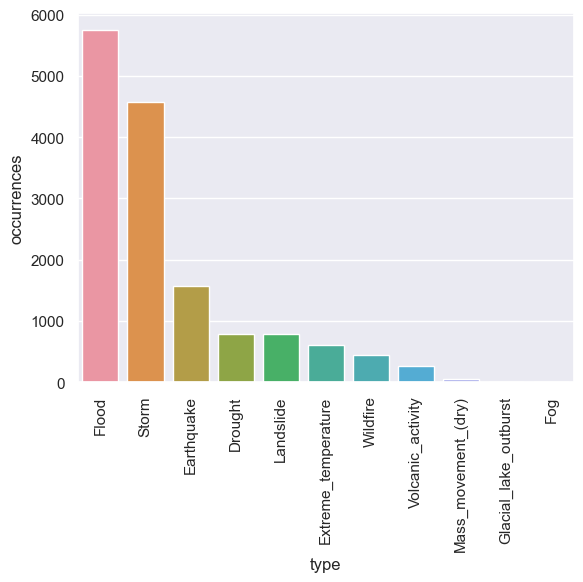

In [99]:
histdata = dis_global.groupby('type').count()
histdata.reset_index(inplace=True)
histdata.rename(columns={'year': 'occurrences'}, inplace=True)
histdata.sort_values('occurrences', inplace=True, ascending=False)
hist = sns.barplot(data=histdata.reset_index(), x='type', y='occurrences')
hist.tick_params(axis='x', rotation=90);

Storms and Floods occur by far the most often while disasters like droughts, earthquakes occur fewer times. The other types of disasters are very rare with only 3 recorded observations of glacial lake outbursts. Living next to the water seems to be dangerous!

### How deadly are natural disasters?
#### By Type

In [100]:
dis_deaths_by_type = dis_global.groupby(["type"])
dis_deaths_by_type = dis_deaths_by_type.sum(numeric_only=True).drop("year", axis=1)
dis_deaths_by_type.sort_values(by="deaths",ascending=False)

,deaths
type,
Drought,11733889.0
Flood,7002992.0
Earthquake,2343912.0
Storm,1403609.0
Extreme_temperature,194056.0
Volcanic_activity,86893.0
Landslide,67477.0
Wildfire,4653.0
Mass_movement_(dry),4644.0


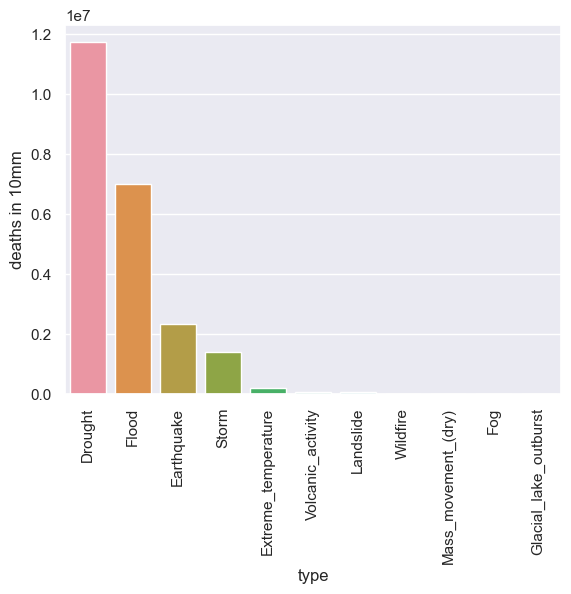

In [101]:
dis_deaths_by_type.reset_index(inplace=True)
dis_deaths_by_type.sort_values('deaths', ascending=False, inplace=True)

barplot = sns.barplot(data=dis_deaths_by_type, x="type", y="deaths")
barplot.tick_params(axis='x', rotation=90)
barplot.set_ylabel("deaths in 10mm")
plt.show()

As expected the cumulative deaths by flood are high with around 7 million people dying in the last 100 years.
The most significant insight here is that droughts have the highest death toll of all disasters with almost 11 mio people dying in the same timeframe. This is remarkable since droughts were only the fifth most common disaster. Storms, which occurred almost als often as floods have a relatively low death toll and are even superseded by the number of people dying from earthquakes.

The lethality of droughts is the most surprising or in this case shocking point.
More people dyed from droughts, probably following week long starvation, than from all other disasters combined.
There is one caveat though: Droughts are not necessarily the result of natural events but rather can be and have been caused by political failure or even have been weaponized by states.

We can also indentify the following types as the main contributors to human deaths by natural disasters:

- Drought
- Flood
- Earthquake
- Storm
- Extreme temperature

In addition to the most lethal disasters, we also choose to include Extreme temperature into our closer examination, since we suspect it to be related to the rising global temperature.
We will take a closer look at those types of disasters in the following.

#### Single Disasters
So lets see what the most lethal disasters of the last one hundred years have been

In [102]:
dis_global.sort_values(by="deaths", ascending = False).drop("subtype", axis=1).head(10)

,year,type,deaths
95,1931,Flood,3700000.0
81,1928,Drought,3000000.0
272,1959,Flood,2000000.0
137,1943,Drought,1900000.0
354,1965,Drought,1500000.0
130,1942,Drought,1500000.0
1,1900,Drought,1250000.0
849,1921,Drought,1200000.0
123,1939,Flood,500000.0
48,1920,Drought,500000.0


The 10 most lethal disasters from the last 100 years have exclusively been floods and droughts. The number one spot is a flood which happened 1931 in China and is known as the deadliest natural disaster of all time.

### How did natural disasters change over time?
#### Occurrences

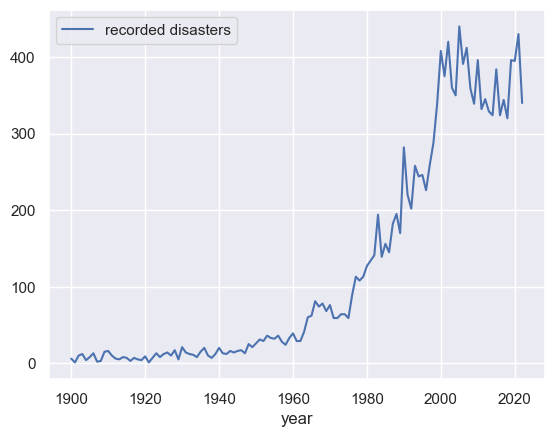

In [103]:
dis_freq_per_year = dis_global.groupby('year').count().drop(["subtype", "deaths"], axis=1)
dis_freq_per_year.rename(columns={'type':'recorded disasters'}, inplace=True)

sns.lineplot(data = dis_freq_per_year);

We can clearly see that the number of recorded disasters skyrocketed over the last 100 years. This is most likely not because there are this much more disasters happening (which affected people), but rather due to states or other institutions increasing their monitoring and taking recording of natural disasters seriously.

#### Death toll

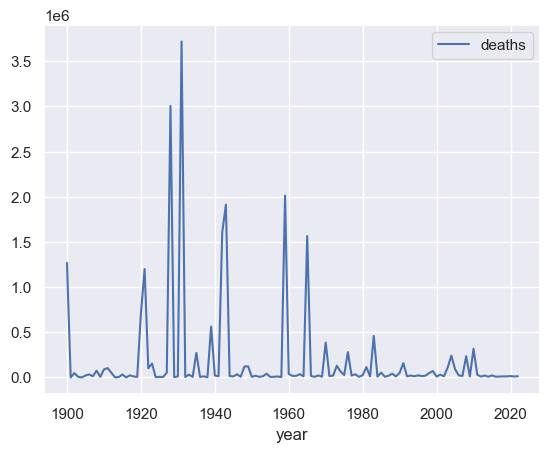

In [104]:
dis_deaths_per_year = dis_global.groupby('year').sum(numeric_only=True)

sns.lineplot(data = dis_deaths_per_year);

This is unexpected. We saw that the frequency of recorded disasters increased strongly over the past 100 years.
But number of people dying from natural disasters certainly has not.
We can also see that those are not linear trends. In certain periods of time, disasters seem to occur that have a dramatically high death toll like in the 1920s-1940s and the 1960s. Other periods like the 1950s have almost no recorded deaths (compared to the significant ones). After that 1960s the recorded deaths per year never came close to that, with only minor spikes occurring in the 2000s.

The 1920s-1940s can maybe be explained due to historic events and their consequences, like the two world wars, the great depression and political systems collapsing all around the world.

For the major disasters happening in the 1960s it is not that obvious to come up with a causal reasoning.
This requires further research.

It is safe to say that humanity as a whole has improved significantly in preventing disasters with a death toll in the millions.

When comparing the deaths by disasters on a normal scale, to see trends, it might be a good idea to exclude those major disasters.

To express how severe the major disasters were in relation to the other disaster, we illustrate them in a boxplot. All the upper outliers are disasters that were so deadly, that the year they occurred is defined by it with all other disasters paling in comparison. That is why some years are extreme outliers.

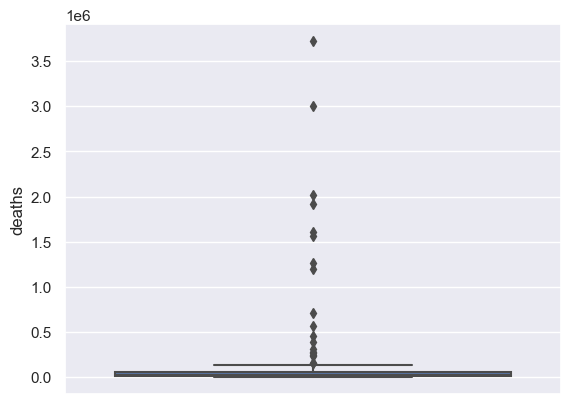

In [105]:
sns.boxplot(y=dis_deaths_per_year["deaths"]);

Disasters tend to show up periodically but not annually, so maybe it makes more sense for a boxplot to visualize the data grouped by decades, not years. We exclude the 2020 decade since our data only contains disasters that happened before 2023. It therefore makes not much sense to include them in the analysis where wo compare absolute occurrences or the sum of all deaths.

#### Occurrences per decade

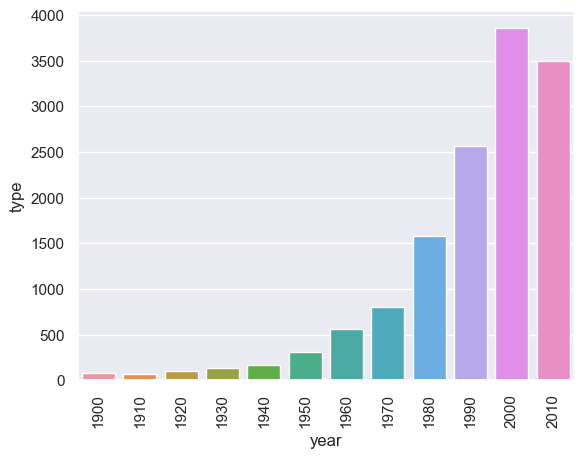

In [106]:
dis_freq_per_decade = dis_global.copy()
dis_freq_per_decade['year'] = dis_freq_per_decade['year'] - dis_freq_per_decade['year'] % 10
dis_freq_per_decade = dis_freq_per_decade.groupby('year')["type"].count()
dis_freq_per_decade.drop([2020], axis=0, inplace=True)
barplot = sns.barplot(data=dis_freq_per_decade.reset_index(), x="year", y="type")
barplot.tick_params(axis='x', rotation=90);

#### Death toll per decade

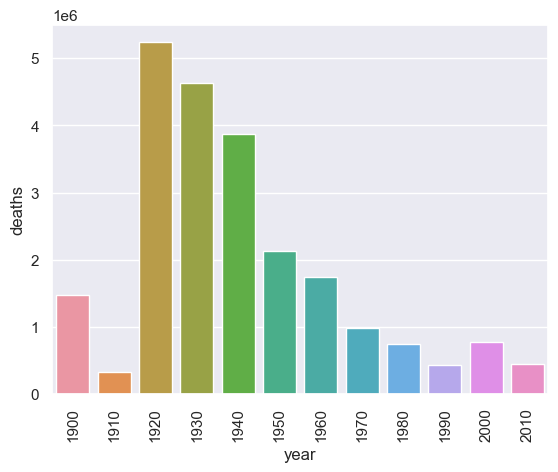

In [107]:
dis_deaths_per_decade = dis_global.copy()
dis_deaths_per_decade['year'] = dis_deaths_per_decade['year'] - dis_deaths_per_decade['year'] % 10
dis_deaths_per_decade = dis_deaths_per_decade.groupby('year').sum(numeric_only = True)
dis_deaths_per_decade.drop([2020], axis=0, inplace=True)
barplot = sns.barplot(data=dis_deaths_per_decade.reset_index(), x="year", y="deaths")
barplot.tick_params(axis='x', rotation=90);

By grouping the data by decades we should now be able to create a reasonable looking boxplot


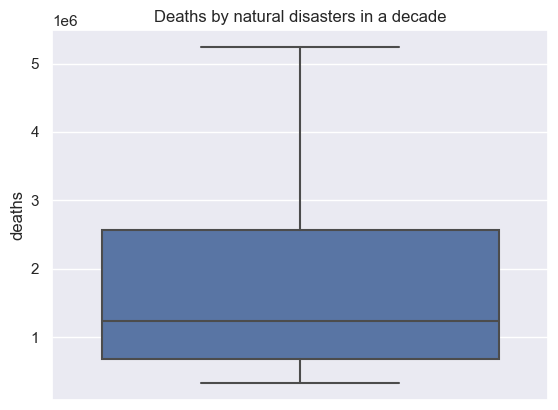

In [108]:
sns.boxplot( y=dis_deaths_per_decade["deaths"]).set(title='Deaths by natural disasters in a decade')
plt.show()

### How do disasters vary by type?
#### Droughts

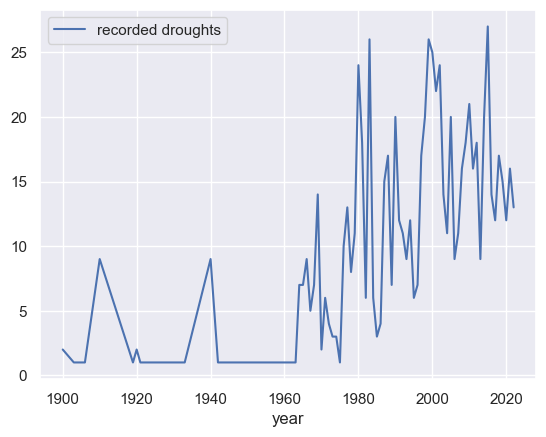

In [109]:
dis_droughts_per_year = dis_global[dis_global.type=="Drought"].groupby('year').count().drop(["subtype", "deaths"], axis=1)
dis_droughts_per_year.rename(columns={'type':'recorded droughts'}, inplace=True)
sns.lineplot(data = dis_droughts_per_year);

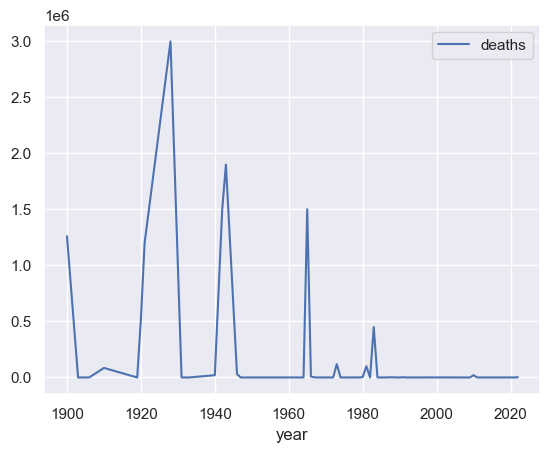

In [110]:
dis_deaths_by_droughts_per_year = dis_global[dis_global.type=="Drought"].groupby('year').sum(numeric_only=True)
sns.lineplot(data = dis_deaths_by_droughts_per_year);

The number of recorded droughts has increases but the number of recorded deaths has decreased. In 40 years no drought has really caused a significant amount of deaths. In the 1920s and the early 1940s extremely lethal droughts occurred. This is also what we saw previously.

#### Floods

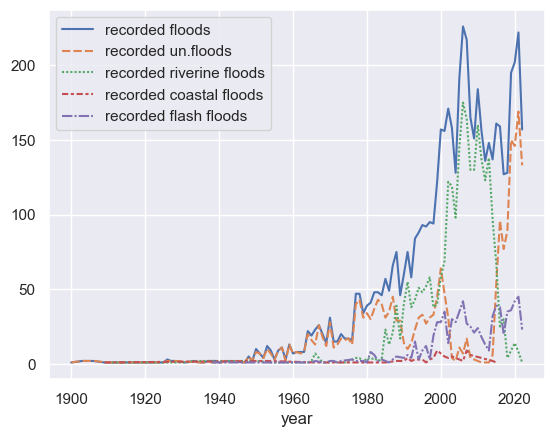

In [111]:
dis_floods_per_year = dis_global[dis_global.type=="Flood"].groupby('year').count().drop(["subtype", "deaths"], axis=1)
dis_floods_uf_per_year = dis_global[dis_global.subtype=="Uncategorized_Flood"].groupby('year').count().drop(["type", "deaths"], axis=1)
dis_floods_rf_per_year = dis_global[dis_global.subtype=="Riverine_flood"].groupby('year').count().drop(["type", "deaths"], axis=1)
dis_floods_cf_per_year = dis_global[dis_global.subtype=="Coastal_flood"].groupby('year').count().drop(["type", "deaths"], axis=1)
dis_floods_ff_per_year = dis_global[dis_global.subtype=="Flash_flood"].groupby('year').count().drop(["type", "deaths"], axis=1)
dis_floods_per_year.rename(columns={'type':'recorded floods'}, inplace=True)
dis_floods_uf_per_year.rename(columns={'subtype':'recorded un.floods'}, inplace=True)
dis_floods_rf_per_year.rename(columns={'subtype':'recorded riverine floods'}, inplace=True)
dis_floods_cf_per_year.rename(columns={'subtype':'recorded coastal floods'}, inplace=True)
dis_floods_ff_per_year.rename(columns={'subtype':'recorded flash floods'}, inplace=True)
dis_floods_freq = [dis_floods_per_year, dis_floods_uf_per_year, dis_floods_rf_per_year, dis_floods_cf_per_year, dis_floods_ff_per_year]
sns.lineplot(data = pd.concat(dis_floods_freq, axis=1));

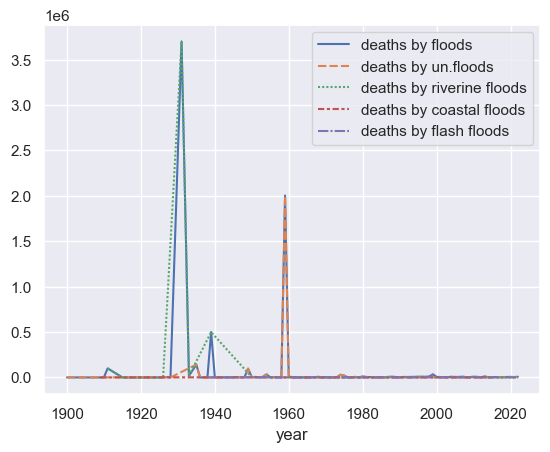

In [112]:
dis_deaths_by_floods_per_year = dis_global[dis_global.type=="Flood"].groupby('year').sum(numeric_only=True)
dis_deaths_by_floods_uf_per_year = dis_global[dis_global.subtype=="Uncategorized_Flood"].groupby('year').sum(numeric_only=True)
dis_deaths_by_floods_rf_per_year = dis_global[dis_global.subtype=="Riverine_flood"].groupby('year').sum(numeric_only=True)
dis_deaths_by_floods_cf_per_year = dis_global[dis_global.subtype=="Coastal_flood"].groupby('year').sum(numeric_only=True)
dis_deaths_by_floods_ff_per_year = dis_global[dis_global.subtype=="Flash_flood"].groupby('year').sum(numeric_only=True)

dis_deaths_by_floods_per_year.rename(columns={'deaths':'deaths by floods'}, inplace=True)
dis_deaths_by_floods_uf_per_year.rename(columns={'deaths':'deaths by un.floods'}, inplace=True)
dis_deaths_by_floods_rf_per_year.rename(columns={'deaths':'deaths by riverine floods'}, inplace=True)
dis_deaths_by_floods_cf_per_year.rename(columns={'deaths':'deaths by coastal floods'}, inplace=True)
dis_deaths_by_floods_ff_per_year.rename(columns={'deaths':'deaths by flash floods'}, inplace=True)

dis_floods_deaths = [dis_deaths_by_floods_per_year, dis_deaths_by_floods_uf_per_year, dis_deaths_by_floods_rf_per_year, dis_deaths_by_floods_cf_per_year, dis_deaths_by_floods_ff_per_year]

sns.lineplot(data = pd.concat(dis_floods_deaths, axis = 1));

In [113]:
dis_deaths_by_floods_uf_per_year.head()

,deaths by un.floods
year,
1900,300.0
1903,250.0
1906,6.0
1910,1379.0
1920,0.0


The number of recorded incidents of floods are increasing, like for the other types or recorded disasters in general. We can see that the most lethal floods have occurred in the early 1930s (e.g. China-Flood) as well as the early 1960s.
Unlike the other types of disaster, floods do not cause a high number of humans lives in other periods, with the annual death toll being negligible for other time spans. Since the 1960s no flood has ever caused a high number of human casualties again. This might be due to more modern ways of predicting floods earlier as well as people being cautious to live in areas where floods are likely and lethal.

#### Earthquake

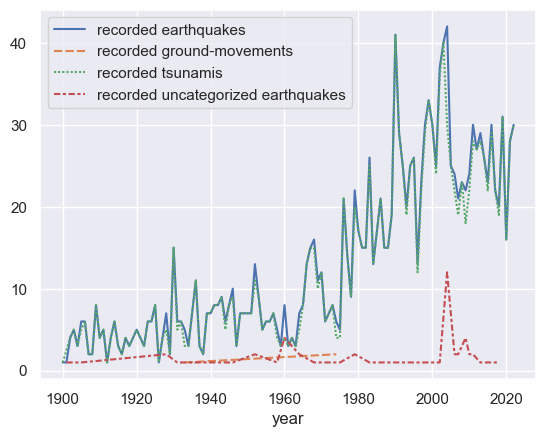

In [114]:
dis_earthquakes_per_year = dis_global[dis_global.type=="Earthquake"].groupby('year').count().drop(["subtype", "deaths"], axis=1)
dis_earthquakes_gm_per_year = dis_global[dis_global.subtype=="Uncategorized_Earthquake"].groupby('year').count().drop(["type", "deaths"], axis=1)
dis_earthquakes_ts_per_year = dis_global[dis_global.subtype=="Ground_movement"].groupby('year').count().drop(["type", "deaths"], axis=1)
dis_earthquakes_ue_per_year = dis_global[dis_global.subtype=="Tsunami"].groupby('year').count().drop(["type", "deaths"], axis=1)

dis_earthquakes_per_year.rename(columns={'type':'recorded earthquakes'}, inplace=True)
dis_earthquakes_gm_per_year.rename(columns={'subtype':'recorded ground-movements'}, inplace=True)
dis_earthquakes_ts_per_year.rename(columns={'subtype':'recorded tsunamis'}, inplace=True)
dis_earthquakes_ue_per_year.rename(columns={'subtype':'recorded uncategorized earthquakes'}, inplace=True)

dis_earthquakes_freq = [dis_earthquakes_per_year, dis_earthquakes_gm_per_year, dis_earthquakes_ts_per_year, dis_earthquakes_ue_per_year]
sns.lineplot(data = pd.concat(dis_earthquakes_freq, axis=1));

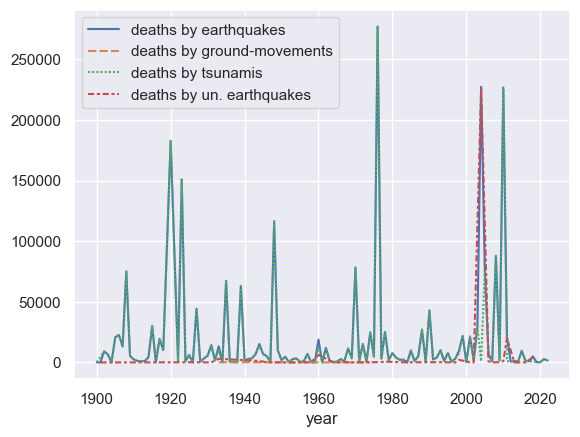

In [115]:
dis_deaths_by_earthquakes_per_year = dis_global[dis_global.type=="Earthquake"].groupby('year').sum(numeric_only=True)
dis_deaths_by_earthquakes_gm_per_year = dis_global[dis_global.subtype=="Uncategorized_Earthquake"].groupby('year').sum(numeric_only=True)
dis_deaths_by_earthquakes_ts_per_year = dis_global[dis_global.subtype=="Ground_movement"].groupby('year').sum(numeric_only=True)
dis_deaths_by_earthquakes_ue_per_year = dis_global[dis_global.subtype=="Tsunami"].groupby('year').sum(numeric_only=True)

dis_deaths_by_earthquakes_per_year.rename(columns={'deaths':'deaths by earthquakes'}, inplace=True)
dis_deaths_by_earthquakes_gm_per_year.rename(columns={'deaths':'deaths by ground-movements'}, inplace=True)
dis_deaths_by_earthquakes_ts_per_year.rename(columns={'deaths':'deaths by tsunamis'}, inplace=True)
dis_deaths_by_earthquakes_ue_per_year.rename(columns={'deaths':'deaths by un. earthquakes'}, inplace=True)

dis_earthquakes_deaths = [dis_deaths_by_earthquakes_per_year, dis_deaths_by_earthquakes_gm_per_year, dis_deaths_by_earthquakes_ts_per_year, dis_deaths_by_earthquakes_ue_per_year]

sns.lineplot(data = pd.concat(dis_earthquakes_deaths, axis=1));

The frequency of all recorded disaster has drastically increased over the last 100 years, but earthquakes seem to be the one disaster type people have been somewhat reliably tracking even in the first part of the 19th century. It still increased, but not as drastically as the other ones.
The recorded deaths per year spiked again in the 1920s, like almost all other types of disasters but also in the late 1970s and the 2000s.
Here we can see that the spikes in deaths we saw earlier in the 2000s probably are caused by those earthquakes. A reason might be that droughts and floods are easier to prevent with modern technology or global aid programs, while earthquakes are more difficult to prevent even in our modern world. They are still nowhere nearly as deadly as the floods and droughts 50 years earlier have been.

#### Storms

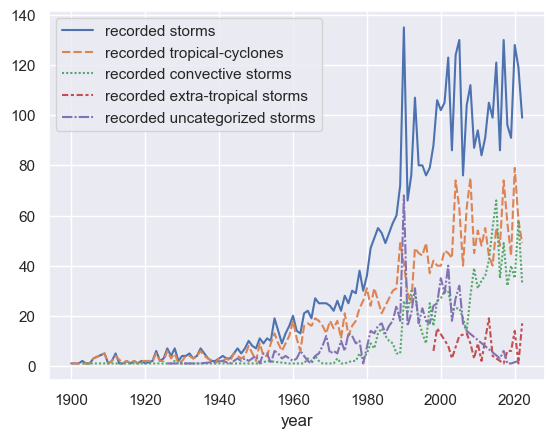

In [116]:
dis_deaths_by_storms_per_year = dis_global[dis_global.type=="Storm"].groupby('year').count().drop(["subtype", "deaths"], axis=1)
dis_deaths_by_storms_tc_per_year = dis_global[dis_global.subtype=="Tropical_cyclone"].groupby('year').count().drop(["type", "deaths"], axis=1)
dis_deaths_by_storms_cs_per_year = dis_global[dis_global.subtype=="Convective_storm"].groupby('year').count().drop(["type", "deaths"], axis=1)
dis_deaths_by_storms_ets_per_year = dis_global[dis_global.subtype=="Extra-tropical_storm"].groupby('year').count().drop(["type", "deaths"], axis=1)
dis_deaths_by_storms_us_per_year = dis_global[dis_global.subtype=="Uncategorized_Storm"].groupby('year').count().drop(["type", "deaths"], axis=1)

dis_deaths_by_storms_per_year.rename(columns={'type':'recorded storms'}, inplace=True)
dis_deaths_by_storms_tc_per_year.rename(columns={'subtype':'recorded tropical-cyclones'}, inplace=True)
dis_deaths_by_storms_cs_per_year.rename(columns={'subtype':'recorded convective storms'}, inplace=True)
dis_deaths_by_storms_ets_per_year.rename(columns={'subtype':'recorded extra-tropical storms'}, inplace=True)
dis_deaths_by_storms_us_per_year.rename(columns={'subtype':'recorded uncategorized storms'}, inplace=True)

dis_storms_deaths = [dis_deaths_by_storms_per_year, dis_deaths_by_storms_tc_per_year, dis_deaths_by_storms_cs_per_year, dis_deaths_by_storms_ets_per_year, dis_deaths_by_storms_us_per_year]

sns.lineplot(data = pd.concat(dis_storms_deaths, axis=1));

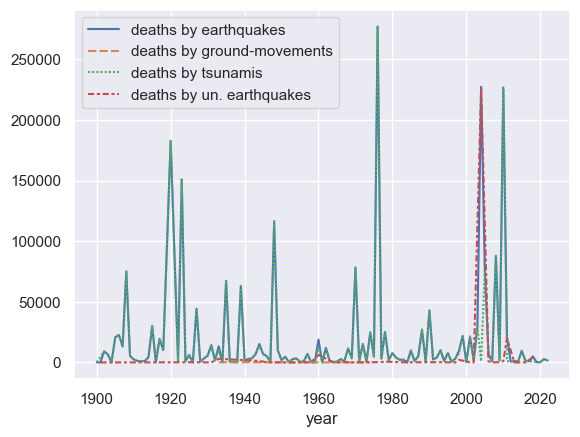

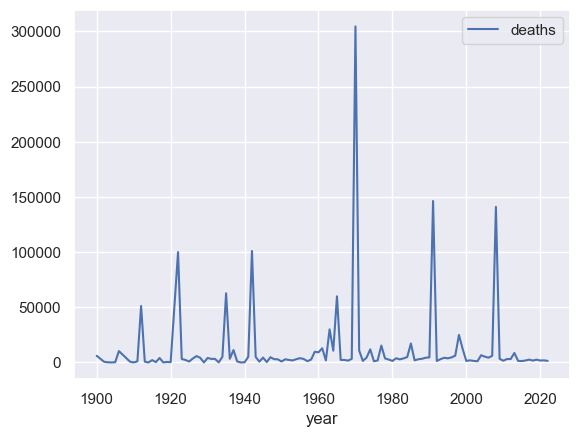

In [117]:
dis_deaths_by_storms_per_year = dis_global[dis_global.type=="Earthquake"].groupby('year').sum(numeric_only=True)
dis_deaths_by_storms_ts_per_year = dis_global[dis_global.subtype=="Uncategorized_Earthquake"].groupby('year').sum(numeric_only=True)
dis_deaths_by_storms_cs_per_year = dis_global[dis_global.subtype=="Ground_movement"].groupby('year').sum(numeric_only=True)
dis_deaths_by_storms_ets_per_year = dis_global[dis_global.subtype=="Tsunami"].groupby('year').sum(numeric_only=True)
dis_deaths_by_storms_us_per_year = dis_global[dis_global.subtype=="Tsunami"].groupby('year').sum(numeric_only=True)

dis_deaths_by_storms_per_year.rename(columns={'deaths':'deaths by storms'}, inplace=True)
dis_deaths_by_storms_ts_per_year.rename(columns={'deaths':'deaths by tropical-cyclones'}, inplace=True)
dis_deaths_by_storms_cs_per_year.rename(columns={'deaths':'deaths by convective storms'}, inplace=True)
dis_deaths_by_storms_ets_per_year.rename(columns={'deaths':'deaths by extra-tropical storms'}, inplace=True)
dis_deaths_by_storms_us_per_year.rename(columns={'deaths':'deaths by uncategorized storms'}, inplace=True)

dis_earthquakes_deaths = [dis_deaths_by_earthquakes_per_year, dis_deaths_by_earthquakes_gm_per_year, dis_deaths_by_earthquakes_ts_per_year, dis_deaths_by_earthquakes_ue_per_year]

sns.lineplot(data = pd.concat(dis_earthquakes_deaths, axis=1))
plt.show()

dis_deaths_by_storms_per_year = dis_global[dis_global.type=="Storm"].groupby('year').sum(numeric_only=True)
sns.lineplot(data = dis_deaths_by_storms_per_year);

Like all disasters, the number of recorded storms has drastically increased over the past 100 years. Noticeable is that the recorded deaths by storms seem to be the most consistent over the years. Looking at the plot we can see that roughly every 20 years storms occurs which cause a great amount of human casualties. Maybe this can be linked to the periodical behaviour of storms such as El Niño. Significant is also the storm in the 1970s which has by far the highest death toll. Let us take a closer look at this one.

In [118]:
dis_deaths_by_storms_per_year.sort_values(by="deaths", ascending = False).head()

,deaths
year,
1970,304495.0
1991,146297.0
2008,140985.0
1942,101000.0
1922,100000.0


This disaster was a storm named the “1970 Bhola cyclone”, also known as the “Great Cyclone of 1970” and was a tropcial cyclone that hit East-Pakistan (present-day Bangladesh) and parts of India. It killed as much as 3 million people and went down in history as one of the deadliest natural disasters of all time. It was the strongest cyclonic storm of the 1970 North Indian Ocean cyclone season.

#### Extreme Temperature

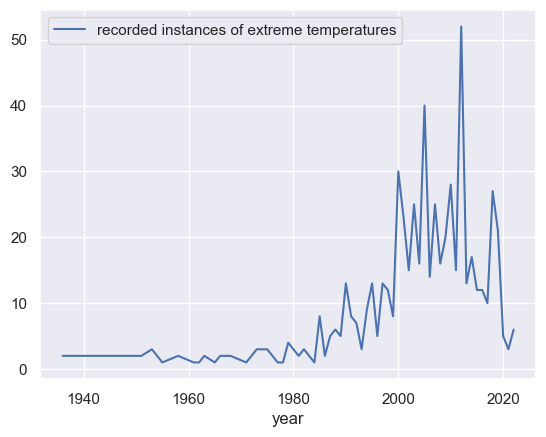

In [119]:
dis_extemp_freq_per_year = dis_global[dis_global.type=="Extreme_temperature"].groupby('year').count().drop(["subtype", "deaths"], axis=1)
dis_extemp_freq_per_year.rename(columns={'type':'recorded instances of extreme temperatures'}, inplace=True)
sns.lineplot(data = dis_extemp_freq_per_year);

We can observe that like most other disasters, extreme weather as a natural disaster was not even recorded prior to the 1940s. Furthermore, occurrences in a decently sized annual number have only started to appear since the start of the 1980s.

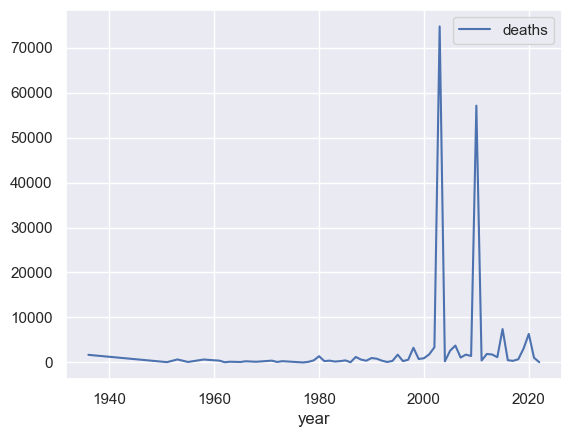

In [120]:
dis_extemp_deaths_per_year = dis_global[dis_global.type=="Extreme_temperature"].groupby('year').sum(numeric_only=True)
dis_extemp_deaths_per_year.head()
dis_extemp_deaths_per_year.rename(columns={'type':'recorded extreme temperatures'}, inplace=True)
sns.lineplot(data = dis_extemp_deaths_per_year);

The plot shows that almost nobody died as a result of extreme weather conditions prior to the year 2000. While the deaths increased over time from 2000 until now, 2 years with an exorbitant death toll stand out in particular.

In [121]:
dis_extemp_deaths_per_year.sort_values(by="deaths", ascending = False).head(3)

,deaths
year,
2003,74698.0
2010,57088.0
2015,7425.0


Upon closer inspection we see that the years 2003 and 2010 have a death toll that is bigger than all other by orders of magnitude. I suspect that these high numbers of deaths were caused by heat waves, since they are by far the most deadly.

In [122]:
dis_extemp_deaths = dis_global[dis_global.subtype=="Heat_wave"]
dis_extemp_deaths.sort_values(by="deaths", ascending = False).head(3)

,year,type,subtype,deaths
10405,2010,Extreme_temperature,Heat_wave,55736.0
7566,2003,Extreme_temperature,Heat_wave,20089.0
7563,2003,Extreme_temperature,Heat_wave,19490.0


As expected, we see that the spikes in deaths in 2010 and 2003 were mainly caused by intense heat waves. The surprise comes with location at the location. This all happened in europe, which was previously almost never had problems with people dying from natural disasters, excluding the time before the 1970s. In 2003 europe saw the hottest summer recorded in Europe since at least 1540.

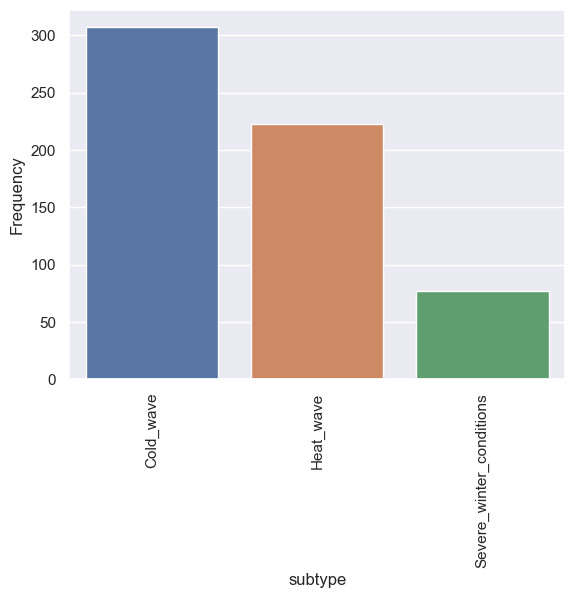

In [123]:
dis_extemp_freq_per_subtype = dis_global[dis_global.type=="Extreme_temperature"].reset_index().drop(columns=['year', 'deaths'], axis=1).groupby('subtype').count()
barplot = sns.barplot(data=dis_extemp_freq_per_subtype.reset_index(), x="subtype", y="type")
barplot.tick_params(axis='x', rotation=90)
barplot.set_ylabel("Frequency");

Cold waves are more common than heat waves but not by much. Recorded instances of severe winter conditions are rare in comparison. Nonetheless, we need to split the observations by subtype if we want to inspect the deaths by heat waves in relationship to rising global temperatures later on.

##### Occurrences of subtypes of extreme weather conditions

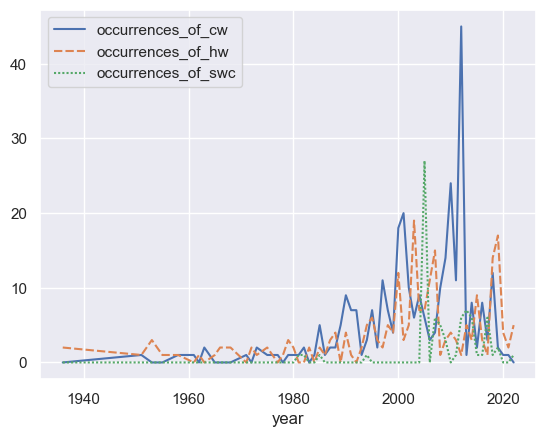

In [124]:
dis_coldwave_freq_per_year = dis_global[dis_global.subtype=="Cold_wave"].groupby('year').size().rename("occurrences_of_cw", inplace=True)
dis_heatwave_freq_per_year = dis_global[dis_global.subtype=="Heat_wave"].groupby('year').size().rename("occurrences_of_hw", inplace=True)
dis_swc_freq_per_year = dis_global[dis_global.subtype=="Severe_winter_conditions"].groupby('year').size().rename("occurrences_of_swc", inplace=True)
dis_freq_per_year_per_subtype = pd.concat([dis_coldwave_freq_per_year, dis_heatwave_freq_per_year, dis_swc_freq_per_year], axis=1).fillna(0)
sns.lineplot(data=dis_freq_per_year_per_subtype);

It is apparent that years with a exceptionally number of occurrences by cold waves are happening since the early 2000s, which can not be said about the other forms of extreme temperature. Spikes in the number of heat waves per year have nonetheless become much more common in the 2000s and beyond.
Like most other disasters, tracking them reliably has only really started in the last 50 years. With extreme weather conditions this is even more extreme, with observations only showing up in decent numbers around the 1990s. Surely extreme weather conditions have happened before in similar numbers but where probably not recorded. This might be due to the nature of these kinds of disasters. An earthquake is much flashier in its effects, than really high temperatures around the country for several days or weeks. 95% of people could be totally fine when a heatwave in vienna is happening for example, with some people even enjoying it. This makes them nonetheless dangerous for a small number of vulnerable people, especially the elderly.

##### Death toll of subtypes of extreme weather conditions

In [125]:
dis_extemp_deaths_per_subtype = dis_global[dis_global.type=="Extreme_temperature"].reset_index().groupby('subtype').sum(numeric_only=True)
dis_extemp_deaths_per_subtype["deaths"].sort_values(ascending = False)

subtype
Heat_wave                   172555.0
Cold_wave                    17765.0
Severe_winter_conditions      3736.0
Name: deaths, dtype: float64

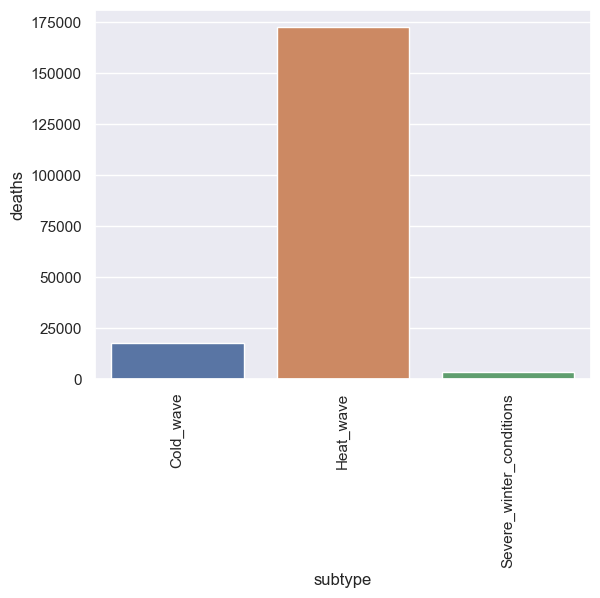

In [126]:
barplot = sns.barplot(data=dis_extemp_deaths_per_subtype.reset_index(), x="subtype", y="deaths")
barplot.tick_params(axis='x', rotation=90)
barplot.set_ylabel("deaths");

According to our data, Heat waves are by far the most dangerous subtype of extreme weather conditions, with over 90% of all deaths by this type of disasters caused by them.

##### Death toll per year over time

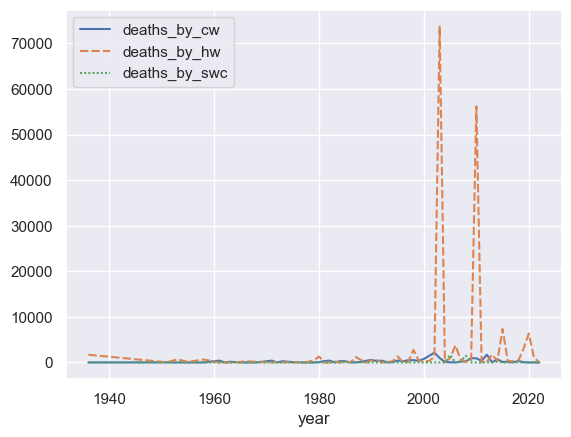

In [127]:
dis_coldwave_deaths_per_year = dis_global[dis_global.subtype=="Cold_wave"].groupby('year').sum(numeric_only=True)
dis_coldwave_deaths_per_year.rename(columns={"deaths":"deaths_by_cw"}, inplace=True)
dis_heatwave_deaths_per_year = dis_global[dis_global.subtype=="Heat_wave"].groupby('year').sum(numeric_only=True)
dis_heatwave_deaths_per_year.rename(columns={"deaths":"deaths_by_hw"}, inplace=True)
dis_swc_deaths_per_year = dis_global[dis_global.subtype=="Severe_winter_conditions"].groupby('year').sum(numeric_only=True)
dis_swc_deaths_per_year.rename(columns={"deaths":"deaths_by_swc"}, inplace=True)
dis_deaths_per_year_per_subtype = pd.concat([dis_coldwave_deaths_per_year, dis_heatwave_deaths_per_year, dis_swc_deaths_per_year], axis=1).fillna(0)
sns.lineplot(data=dis_deaths_per_year_per_subtype);

Since we do not have much data for disasters of type extreme temperature, out graph is distorted. To get a better sense of a trend, let us now group the data by decades. We remove the cumulated data from the present decade since it just started.

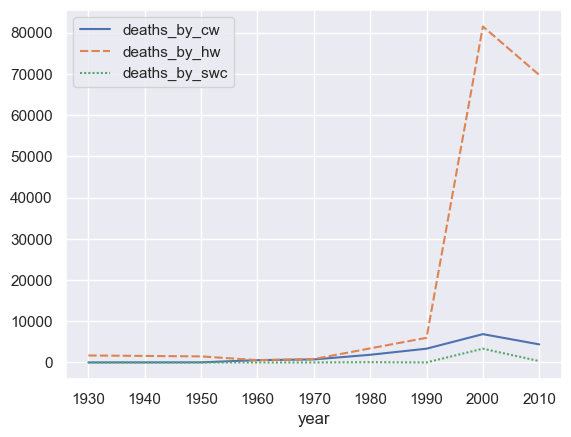

In [128]:
dis_extemp_deaths_per_decade = dis_deaths_per_year_per_subtype.reset_index()
dis_extemp_deaths_per_decade['year'] = dis_extemp_deaths_per_decade['year'] - dis_extemp_deaths_per_decade['year'] % 10
dis_extemp_deaths_per_decade = dis_extemp_deaths_per_decade.groupby('year').sum(numeric_only=True)
dis_extemp_deaths_per_decade.drop([2020], axis=0, inplace=True)
dis_extemp_deaths_per_decade.tail()
sns.lineplot(dis_extemp_deaths_per_decade);

Now we can observe the trend more clearly, the number of deaths by heatwaves has significantly increased since the 1990s. For the two other subtypes, cold waves and severe winter condition, this is can not be said. Their death toll per year mostly stayed the same. Especially for deaths by cold waves, this is odd, since their number increased the most after the turn of the century.

### How did the population change over time
#### Globally

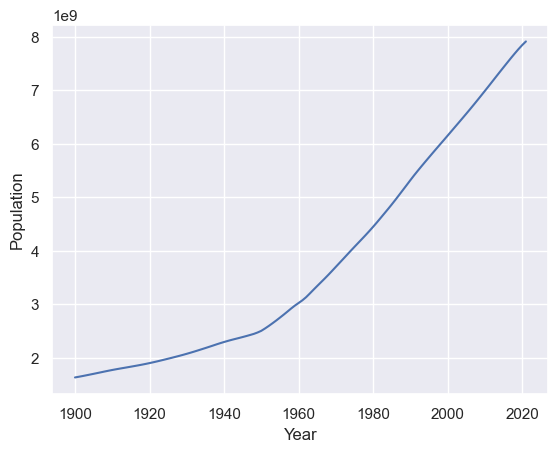

In [129]:
pop_global_df_plot = sns.lineplot(data=pop_global_df, x='year', y='population')
pop_global_df_plot.set_ylabel("Population")
pop_global_df_plot.set_xlabel("Year");

This plot shows the world population from 1900 until 2021. We can observe a significant change in the population growth after WW2 - often referred as the ‘boomer generation’. After that, the population growth did not stagnate until now. Let’s take a look at the population trend in the specified regions.

#### Regionally

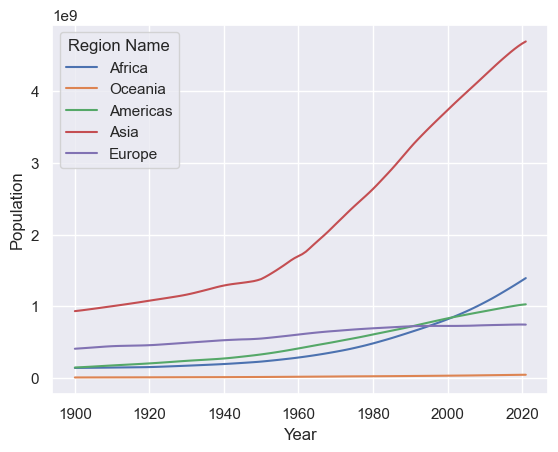

In [130]:
pop_regions_plot = sns.lineplot(data=pop_regions_df, x='year', y='population', estimator=None, hue='region_name')
pop_regions_plot.set_ylabel("Population")
pop_regions_plot.set_xlabel("Year")
pop_regions_plot.get_legend().set_title("Region Name");

The above plot shows the population development of the specified regions. As expected, the population of Asia grew significantly faster, than the population of other regions. In Europe, the population slightly increased, but with the slowest growing rate. Both America and Africa show an upwards trend since the 1950´s.
 We will use the population data, to calculate the relative death rate of natural disasters.

For the analysis of relative deaths, we will only look at disasters where at least one death were recoded.

In [131]:
dis_all_df['deaths'] = dis_all_df['deaths'].fillna(0)
dis_all_df['deaths'] = dis_all_df['deaths'].astype(int)

#extract rows with recorded deaths
dis_all_with_deaths = dis_all_df[dis_all_df['deaths'] > 0]
print(dis_all_with_deaths['deaths'].describe().astype(int))

count      10459
mean        2184
std        60938
min            1
25%            5
50%           17
75%           54
max      3700000
Name: deaths, dtype: int64


### Calculate relative deaths

Now we can merge the disaster and the population dataset into on dataframe. Within this dataframe, we can calculate the relative death rate for each individual disaster.

In [132]:
dis_all_with_rel_deaths = pd.merge(dis_all_with_deaths, pop_country_df, how='left', on=['year', 'country_code', 'country_name'])
dis_all_with_rel_deaths['rel_deaths'] = dis_all_with_rel_deaths['deaths']/dis_all_with_rel_deaths['population']

From this dataset, we can derive a global, a regional and a dataset on country-level.

In [133]:
#get global dataset
dis_global_df = dis_all_with_rel_deaths.groupby('year').sum('deaths')
dis_global_df.reset_index(inplace=True)
dis_global_df = dis_global_df[['year', 'deaths']]
dis_global_df = dis_global_df.merge(pop_global_df, on='year')
dis_global_df['rel_deaths'] = dis_global_df['deaths'] / dis_global_df['population']
dis_global_df = dis_global_df[['year', 'deaths', 'rel_deaths']]
dis_global_df.head()

,year,deaths,rel_deaths
0,1900,1267470,7.789634e-04
1,1901,18,1.097772e-08
2,1902,48438,2.930489e-05
3,1903,7136,4.281359e-06
4,1904,152,9.043314e-08


In [134]:
#get regional dataset
dis_region_df = dis_all_with_rel_deaths.groupby(['year', 'region_name', 'region_code', 'type']).sum('deaths')
dis_region_df.reset_index(inplace=True)
dis_region_df = dis_region_df[['year', 'region_name', 'region_code' ,'deaths', 'type']]
dis_region_df = dis_region_df.merge(pop_regions_df, on=['year', 'region_code', 'region_name'])
dis_region_df['rel_deaths'] = dis_region_df['deaths'] / dis_region_df['population']
dis_region_df = dis_region_df[['year', 'region_name', 'region_code', 'deaths', 'rel_deaths', 'type']]
dis_region_df.sort_values(['region_name', 'year'], inplace=True)
dis_region_df.reset_index(inplace=True)
dis_region_df.head()

,index,year,region_name,region_code,deaths,rel_deaths,type
0,0,1900,Africa,2.0,11000,7.937736e-05,Drought
1,12,1903,Africa,2.0,17,1.214348e-07,Volcanic_activity
2,33,1909,Africa,2.0,100,6.978114e-07,Earthquake
3,40,1910,Africa,2.0,85000,5.907286e-04,Drought
4,41,1910,Africa,2.0,12,8.339698e-08,Earthquake


In [135]:
#get country dataset
dis_country_df = dis_all_with_rel_deaths.groupby(['year', 'country_code', 'country_name']).sum('deaths')
dis_country_df.reset_index(inplace=True)
dis_country_df = dis_country_df[['year', 'country_code', 'country_name', 'deaths', 'rel_deaths']]
dis_country_df.head()

,year,country_code,country_name,deaths,rel_deaths
0,1900,CPV,Cabo Verde,11000,0.000000e+00
1,1900,IND,India,1250000,4.452928e-03
2,1900,JAM,Jamaica,300,4.122714e-04
3,1900,JPN,Japan,30,6.754246e-07
4,1900,TUR,Turkey,140,1.001955e-05


In [136]:
# define a helper function for barplots.
def getTwinxBarPlot(data, xcolumn, ycolumn1, ycolumn2, xlabel, title):
    ax = sns.barplot(data=data, x=xcolumn, y=ycolumn1, errorbar=None, color='steelblue', label='Number of deaths')

    width_scale = 0.45
    for bar in ax.containers[0]:
        bar.set_width(bar.get_width() * width_scale)
    ax.grid(False)
    ax.set_ylabel('Number of deaths')
    ax.set_xlabel(xlabel)
    ax.set_title(title)

    ax2 = ax.twinx()
    sns.barplot(data=data, x=xcolumn, y=ycolumn2, ax=ax2, color='orange', label=' Relative number of deaths')
    for bar in ax2.containers[0]:
        x = bar.get_x()
        w = bar.get_width()
        bar.set_x(x + w * (1- width_scale))
        bar.set_width(w * width_scale)
    ax2.grid(False)
    ax2.set_ylabel('Relative number of deaths')

### How do disasters vary by region?

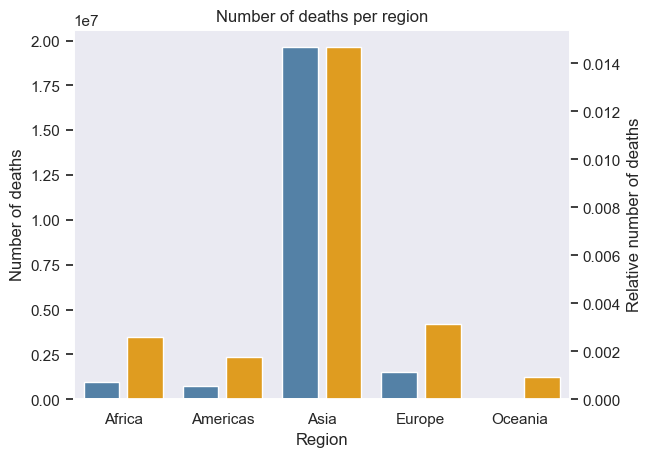

In [137]:
#sum of deaths per region
dis_region_df_sum = dis_region_df.groupby('region_name').sum(numeric_only=True)
dis_region_df_sum.reset_index(inplace=True)
dis_region_df_sum = dis_region_df_sum[['region_name', 'deaths', 'rel_deaths']]

getTwinxBarPlot(dis_region_df_sum, 'region_name', 'deaths', 'rel_deaths', 'Region', 'Number of deaths per region')

This plot shows both, the number of deaths per region (blue) and the relative number of deaths per region (orange). We can see, that Asia has by far the most deaths and relative deaths. Lets take a closer look at natural disasters happened in Asia.

#### Asia

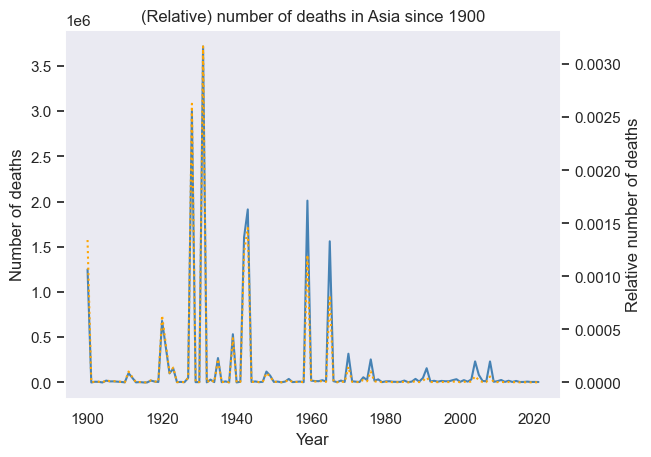

In [138]:
dis_region_asia = dis_region_df[dis_region_df['region_name'] == 'Asia']
dis_region_asia = dis_region_asia.groupby('year').sum(numeric_only=True)

#deaths and relative deaths over time
ax = sns.lineplot(data=dis_region_asia, x='year', y='deaths', color='steelblue')
ax.grid(False)
ax.set_ylabel('Number of deaths')
ax.set_xlabel('Year')
ax.set_title('(Relative) number of deaths in Asia since 1900')

ax2 = ax.twinx()
ax2 = sns.lineplot(data=dis_region_asia, x='year', y='rel_deaths', color='orange', linestyle=':')
ax2.set_ylabel('Relative number of deaths')
ax2.grid(False);

This figure shows the number of deaths and relative number of deaths in Asia. Note that both y-axis are scaled to the max value. The biggest natural disaster happened in 1931. Since then, the number of deaths decreased. Due to the rapid population growth of asia, the relative death rate per disaster decreased even more. After 1965 the deaths of natural disasters sharply declined and no major disaster (deaths > 500000) occurred. Lets compare those results to Europe.

#### Europe

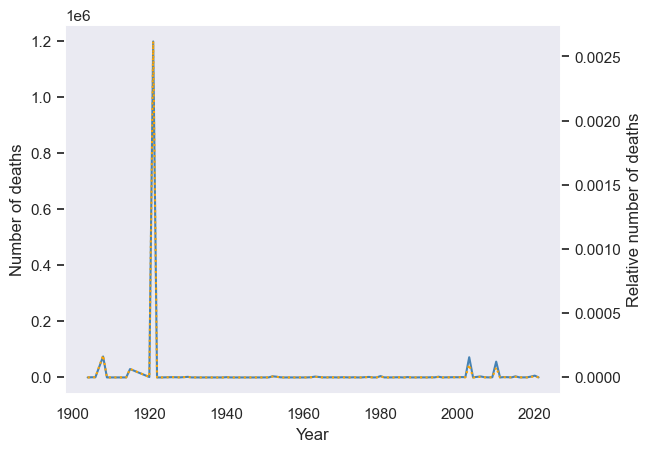

In [139]:
dis_region_europe = dis_region_df[dis_region_df['region_name'] == 'Europe']
dis_region_europe = dis_region_europe.groupby('year').sum(numeric_only=True)

#deaths and relative deaths over time
ax = sns.lineplot(data=dis_region_europe, x='year', y='deaths', color='steelblue')
ax.grid(False)
ax.set_ylabel('Number of deaths')
ax.set_xlabel('Year')

ax2 = ax.twinx()
ax2 = sns.lineplot(data=dis_region_europe, x='year', y='rel_deaths', color='orange', linestyle=':')
ax2.set_ylabel('Relative number of deaths')
ax2.grid(False);

Compared to Asia, Europe had just one major disaster in 1921. There are a total of 5 years with more than 10000 recorded deaths caused by a natural disaster. To gain a better understanding of the differences between the two regions, we take a look at the different disasters types.

#### Compare Asia and Europe by disaster type

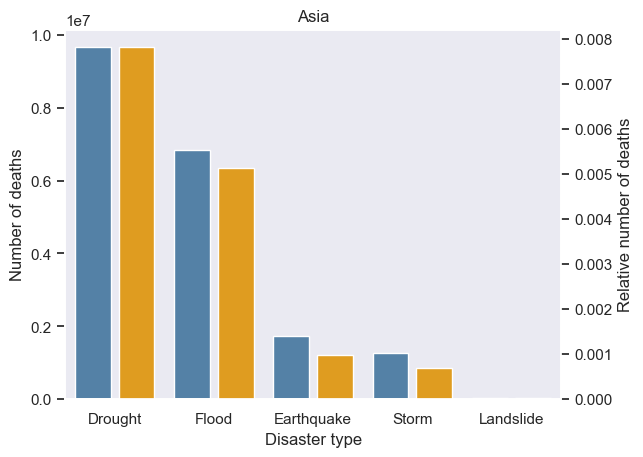

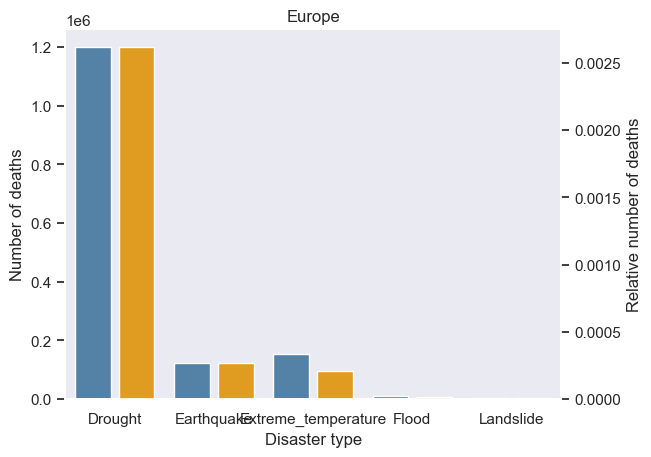

In [140]:
region_names = ['Asia', 'Europe']

for index, region in enumerate(region_names):
    dis_region_with_type = dis_region_df.loc[dis_region_df['region_name'] == region, :]
    dis_region_with_type_sum = dis_region_with_type.groupby(['region_name', 'type']).sum(numeric_only=True)
    dis_region_with_type_sum.reset_index(inplace=True)
    dis_region_with_type_sum.sort_values('rel_deaths', inplace=True, ascending=False)
    dis_region_with_type_sum = dis_region_with_type_sum.head(5)

    getTwinxBarPlot(dis_region_with_type_sum, 'type', 'deaths', 'rel_deaths', 'Disaster type', region)
    plt.show()

In both regions, drought is the deadliest type of natural disaster. Note that the number of deaths by a drought in asia exceeds europe's number of deaths by a factor of ten. This could be due to the fact, that asia has a higher population than europe. For this reason we calculated the relative number of deaths to the population. Comparing the relative number of deaths, we see that Asia has still a relative death toll which is almost 3 times higher than the one in europe. Surprisingly, the second-deadliest disaster type in Asia, the flood, is not relevant in europe at all. Let's see, if we can confirm these observations on country level.

### How do disasters vary by country?
First of all, we want to get a feeling for the countries. For this reason we take a look at the deadliest country by number of deaths and relative number of deaths.

In [141]:
dis_country_sum = dis_country_df.groupby(['country_name', 'country_code']).sum(numeric_only=True)
dis_country_sum.reset_index(inplace=True)
dis_country_sum.sort_values('deaths', inplace=True, ascending=False)
dis_country_sum.head(10)

,country_name,country_code,year,deaths,rel_deaths
38,China,CHN,175203,10960627,0.021165
85,India,IND,170049,4591741,0.012099
14,Bangladesh,BGD,135028,2590902,0.061324
176,Soviet Union,SUN,37231,1357423,0.000000
61,Ethiopia,ETH,63835,404750,0.011228
80,Haiti,HTI,87604,245431,0.027285
93,Japan,JPN,195008,239400,0.003551
86,Indonesia,IDN,150430,239103,0.001560
142,Pakistan,PAK,125229,180452,0.003180
87,Iran (Islamic Republic of),IRN,148272,163087,0.000000


As expected, most of the deadliest countries are in Asia. Surprisingly, Ethiopia and Haiti are also present in the Top 10. Let’s see if there is a difference in the relative deaths.

In [142]:
dis_country_sum.sort_values('rel_deaths', inplace=True, ascending=False)
dis_country_sum.head(10)

,country_name,country_code,year,deaths,rel_deaths
14,Bangladesh,BGD,135028,2590902,0.061324
53,Dominica,DMA,13927,2140,0.050000
18,Belize,BLZ,17837,1860,0.031392
80,Haiti,HTI,87604,245431,0.027285
76,Guatemala,GTM,73858,79497,0.025574
38,China,CHN,175203,10960627,0.021165
37,Chile,CHL,87205,60521,0.012768
85,India,IND,170049,4591741,0.012099
61,Ethiopia,ETH,63835,404750,0.011228
127,Mozambique,MOZ,73995,104094,0.008851


The Top 10 of the relative deaths show a completely different picture. While China went from the first place to the 6th place, Bangladesh is still a leading country. An interesting fact is the location of these countries. Only three countries are in Asia, two countries are in Africa and five countries are from middle and south america.

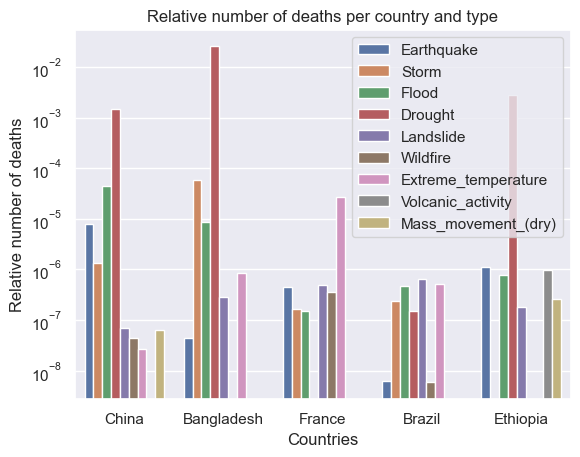

In [143]:
countries = ['China', 'Bangladesh', 'France', 'Brazil', 'Ethiopia']

dis_country_with_type = dis_all_with_rel_deaths.loc[dis_all_with_rel_deaths['country_name'].isin(countries), ['year', 'country_name', 'deaths', 'rel_deaths', 'type', 'subtype']]

ax = sns.barplot(data=dis_country_with_type, x='country_name', y='rel_deaths', hue='type', errorbar=None)
ax.set_yscale('log')
ax.legend(loc='upper right')
ax.set_xlabel('Countries')
ax.set_ylabel('Relative number of deaths')
ax.set_title('Relative number of deaths per country and type');

This plot shows the relative number of deaths by type for the selected countries. We based our selection on previous insights into regional data. Additionally, we added countries to compare regions with each other.
China was chosen because it is the country which was most severally struck by natural disasters in the past, having the highest absolute number of deaths from natural disasters while Bangladesh was included because it has the highest relative number of deaths. Compared to China and Bangladesh, Brazil has a vanishing small amount of deaths by droughts and France do not have recorded deaths by droughts at all.

### Calculate temperature smoothing

We apply lowess smoothing to the temperature anomaly data and add it to our datasets.

In [144]:
# applies lowess smoothing to each group
# if no group is supplied lowess will be applied to the whole dataset
def lowess_grouped(data: pd.DataFrame, x_name: str, y_name: str, group_name, frac: float):
    df = data.copy()
    y_name_smoothed = y_name + "_smooth"
    if group_name is not None:
        groups = df[group_name].unique().tolist()
        smoothed_dfs = []
        for group in groups:
            df_by_select_group = df[df[group_name] == group]
            smoothed_df = sm.nonparametric.lowess(df_by_select_group[y_name],df_by_select_group[x_name],frac=frac)
            smoothed_df = pd.DataFrame(smoothed_df)
            smoothed_df.columns = [x_name, y_name_smoothed]
            smoothed_df[x_name] = smoothed_df[x_name].astype(int)
            smoothed_df[group_name] = group
            smoothed_dfs.append(smoothed_df)
        return pd.merge(df,pd.concat(smoothed_dfs), how="left", on=[x_name,group_name])
    else:
        smoothed_df = sm.nonparametric.lowess(df[y_name], df[x_name], frac=frac)
        smoothed_df = pd.DataFrame(smoothed_df)
        smoothed_df.columns = [x_name, y_name_smoothed]
        return pd.merge(df,smoothed_df, how="left", on=x_name)

In [145]:
temp_global = lowess_grouped(temp_global, "year", "temperature_anomaly", None, frac=0.05)
temp_region = lowess_grouped(temp_region, "year", "temperature_anomaly", "region_name", frac=0.05)
temp_country = lowess_grouped(temp_country, "year", "temperature_anomaly", "country_name", frac=0.05)

### How did the temperature change over time

#### Global temperature trend

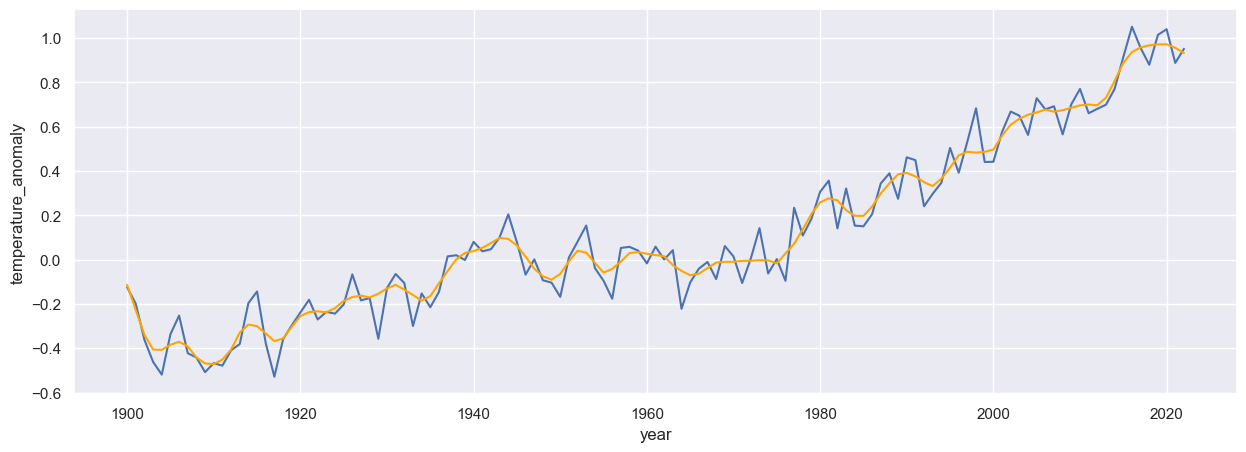

In [146]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x="year", y="temperature_anomaly", data=temp_global)
sns.lineplot(x="year", y="temperature_anomaly_smooth", data=temp_global, color="orange");

In the plot we can observe what seems to be a positive trend for the temperature anomalies, especially in the last 20 years all temperature anomalies have a positive value.

We fit a linear regression to the smoothed temperature anomaly data, to observe what seems like a positive trend further.

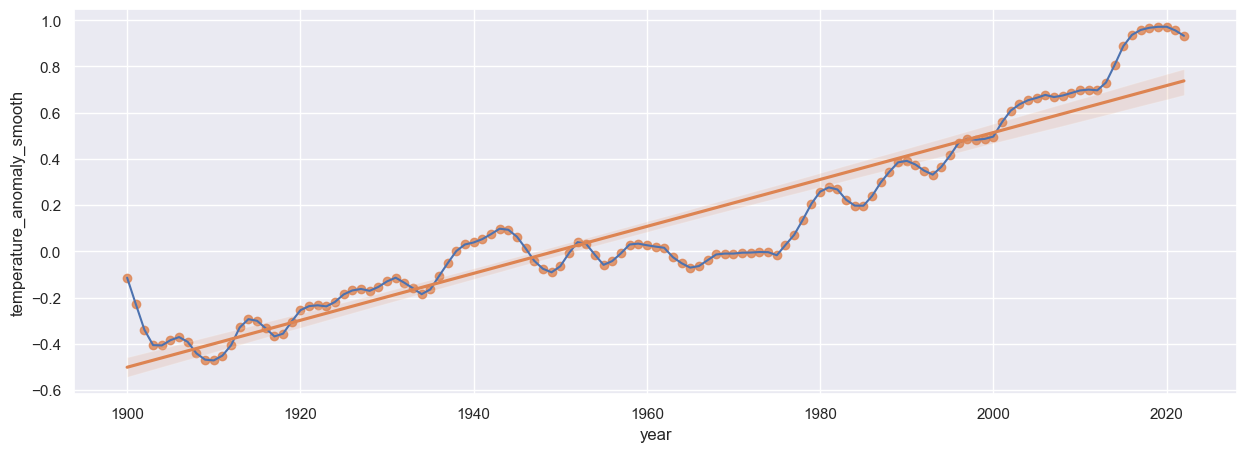

In [147]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x="year", y="temperature_anomaly_smooth", data=temp_global)
sns.regplot(x="year", y="temperature_anomaly_smooth", data=temp_global);

When fitting a linear regression to the temperature anomaly data, the positive trend for the past 120 years becomes clearly visible.

#### Regional temperature trend

We plot the smoothed temperature anomaly data for the regions Africa, Oceania, Americas, Asia and Europe.

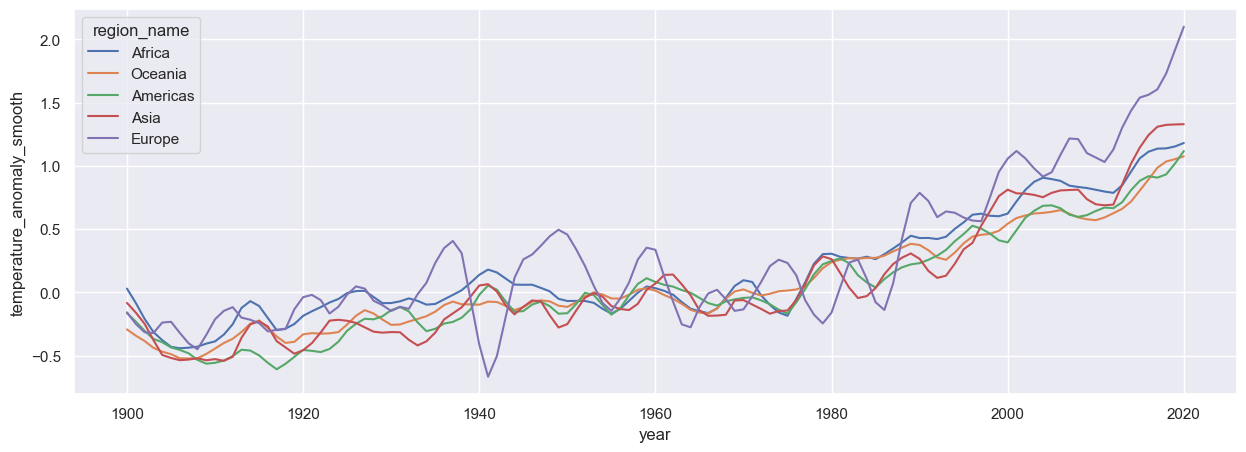

In [148]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x="year", y="temperature_anomaly_smooth", hue="region_name", data=temp_region, ax=ax);

Again, we can see what seems to be a positive trend, with an especially stronger increase in the past 20 years. Europe seems to have the most extreme temperature anomalies and the strongest increase in the past 20 years.

### Which countries had the most extreme temperature anonamlies?

We try to detect which countries have the most extreme temperature anomalies in our dataset. We use three different approaches:

* Ranking countries based on their 2020 anomalies
* Ranking countries based on the slope parameter of a linear regression fitted to the anomalies
* Ranking countries by count of temperature anomaly outliers

#### High 2020 Anomaly

We sort countries based on their 2020 temperature anomaly values

In [149]:
temp_country[temp_country["year"] == 2020].sort_values(by=["temperature_anomaly_smooth"], ascending=False).head()

,year,country_code,temperature_anomaly,country_name,temperature_anomaly_smooth
27238,2020,LVA,3.315083,Latvia,3.265715
27186,2020,EST,3.403417,Estonia,3.244439
27276,2020,RUS,3.627500,Russia,3.186368
27236,2020,LTU,3.134333,Lithuania,3.181848
27157,2020,BLR,3.101917,Belarus,3.137251


#### High slope of linear regression

In [150]:
temp_regression_countries = []
for country_code in temp_country["country_code"].unique().tolist():
    result = smf.ols(formula="temperature_anomaly ~ year", data=temp_country[temp_country["country_code"] == country_code]).fit()
    temp_regression_countries.append([country_code,result.params["year"]])
temp_regression_countries = pd.DataFrame(temp_regression_countries)
temp_regression_countries.columns = ["country_code","year_slope"]
temp_regression_countries.sort_values(by=["year_slope"],ascending=False)

,country_code,year_slope
135,MNG,0.018051
228,ATA,0.017874
177,SJM,0.017829
106,KGZ,0.016326
104,KAZ,0.016276
...,...,...
185,STP,0.008036
41,COG,0.007833
93,IND,0.007577
129,MEX,0.007145


#### Outlier Count

We plot a boxplot to see if outliers exist in the temperature anomly data.

<AxesSubplot: >

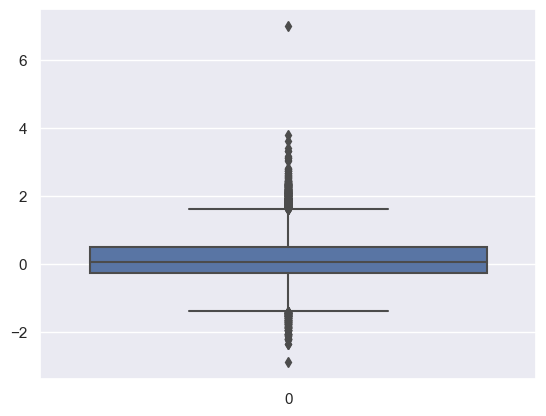

In [151]:
sns.boxplot(temp_country['temperature_anomaly'])

To determine at which value we can consider a temperature anomaly to be an outlier. We will calculate upper and lower bounds for temperature anomalies using the IQR and use these upper and lower bounds to determine outliers.

##### Calculate temperature anomaly IQR

In [152]:
temp_anomalies_np_arr = temp_country['temperature_anomaly'].to_numpy()
temp_anomalies_q3 = np.quantile(temp_anomalies_np_arr, 0.75)
temp_anomalies_q1 = np.quantile(temp_anomalies_np_arr, 0.25)
IQR = temp_anomalies_q3 - temp_anomalies_q1
IQR

0.7557916666666666

##### Calculate upper/lower bound for temp anomaly outliers using IQR

In [153]:
temp_anomaly_upper_bound = temp_anomalies_q3 + 1.5 * IQR
temp_anomaly_lower_bound = temp_anomalies_q1 - 1.5 * IQR
print(temp_anomaly_upper_bound)
print(temp_anomaly_lower_bound)

1.6220625
-1.4011041666666666


##### Detect extreme countries counting outliers based on IQR bounds

1. we filter for countries which include temperature anomaly outliers

2. we count the temperature anomaly outliers for each country and sort them by outlier count

In [154]:
temp_countries_anomaly_outlier = temp_country[(temp_country['temperature_anomaly'] >= temp_anomaly_upper_bound)
                                              | (temp_country['temperature_anomaly'] <= temp_anomaly_lower_bound)][['country_code', 'temperature_anomaly']]

temp_countries_anomaly_outlier = temp_countries_anomaly_outlier.groupby(['country_code']).count().sort_values(['temperature_anomaly'], ascending=False)
temp_countries_anomaly_outlier

,temperature_anomaly
country_code,
SJM,32
FIN,29
EST,25
LVA,22
LTU,22
...,...
MLI,1
SDN,1
MLT,1


### Plotting extreme countries

With our three different approaches we found, that the following five countries are the most extreme for each approach:
* LVA, EST, RUS, LTU, BLR
* MNG, ATA, SJM, KGZ, KAZ
* SJM, FIN, EST, LVA, LTU

Plotting together all the extreme countries would make the plot hard to read, therefore we decide to plot just a few extreme countries. We decide to use the countries SJM and LTU as examples for the extreme countries.

To have a comparison we will add the countries USA and MEX as not extreme examples to the plot.

In [155]:
def plot_countries_temp_anomalies(temp_countries):
    fig, ax = plt.subplots(figsize=(15, 5))
    for i,country_code in enumerate(temp_countries):
        temp_selected_country = temp_country[temp_country["country_code"] == country_code]
        selected_country_name = temp_selected_country["country_name"].iloc[0]
        sns.lineplot(x="year",y="temperature_anomaly_smooth",data=temp_selected_country, ax=ax, label=selected_country_name)
    ax.legend();

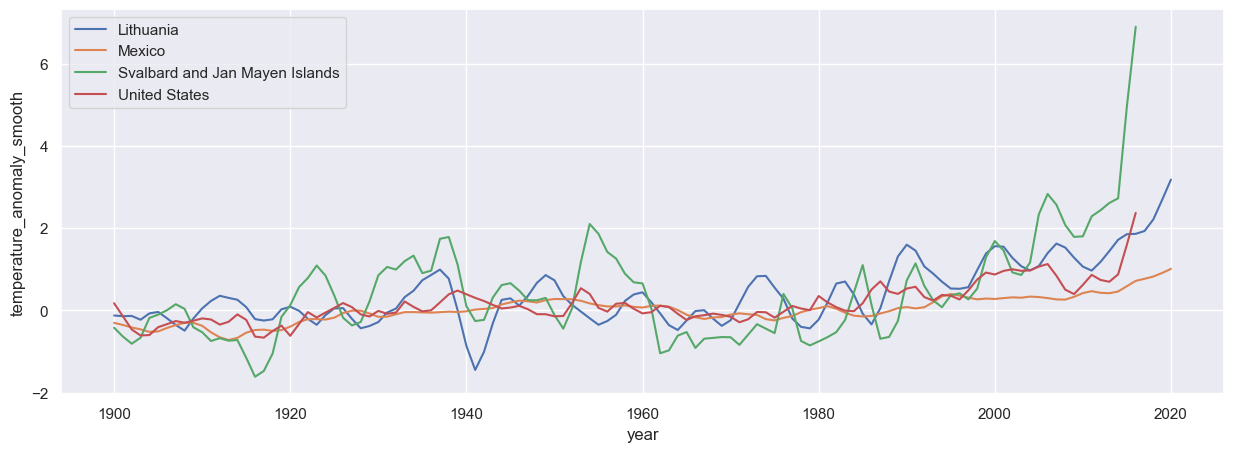

In [156]:
temp_plot_extreme_countries = ["SJM", "LTU", "USA", "MEX"]

temp_plot_extreme_countries = np.unique(temp_plot_extreme_countries)
plot_countries_temp_anomalies(temp_plot_extreme_countries)

As expected, the temperature anomalies of SJM and LTU are more extreme throughout the observed time period compared to the ones of the countries USA and MEX. However the temperature anomalies of all countries rise after 2000

### Do disasters and temperature anomalies correlate?

To observe if a correlation between natural disasters and climate change exist.
For calculating the correlation we use the temperature anomalies and the total number of disaster deaths on a yearly basis.

First we filter the disaster data to just include disasters of the types Drought, Earthquake, Storm, Flood, Wildfire and Extreme temperature.

In [157]:
keep_types = ['Drought', 'Earthquake', 'Storm', 'Flood', 'Wildfire', 'Extreme temperature ']
dis_interesting_types = dis_all.loc[dis_all['type'].isin(keep_types),:]

#### Correlation of total natural disaster deaths with temperature anomalies

We are going to combine disaster and global temperature data to create a DataFrame for further correlation calculation.

First we group the disaster data by year and type and sum up the number of deaths for each year and type.

Then we transform our dataframe to a wide format, to get one row for each year and a column for the deaths of each disaster type.

In [158]:
dis_global_yearly_deaths = dis_interesting_types[['year', 'type', 'deaths']].groupby(['year', 'type']).agg('sum').reset_index()
dis_global_yearly_deaths_wide = pd.pivot(dis_global_yearly_deaths, index='year', columns='type', values='deaths')
dis_global_yearly_deaths_wide.head(3)

type,Drought,Earthquake,Flood,Storm,Wildfire
year,,,,,
1900,1261000.0,140.0,300.0,6000.0,NaN
1901,NaN,18.0,NaN,NaN,NaN
1902,NaN,9148.0,NaN,600.0,NaN


Because not every disaster type occurred each year, we are left with some NaN values, which we replace with 0.

We also change the column names to lowercase, add underscores instead of spaces and add _deaths as a suffix.

In [159]:
def reformatDisGlobalYearlyWide(dis_global_yearly_wide, suffix):
    dis_global_yearly_wide = dis_global_yearly_wide.fillna(0)
    dis_global_yearly_wide = dis_global_yearly_wide.astype('int32')
    dis_global_yearly_wide.columns = [c.replace(' ', '_').lower() for c in dis_global_yearly_wide.columns]
    dis_global_yearly_wide.rename(columns={'extreme_temperature_': 'extreme_temperature', 'mass_movement_(dry)': 'mass_movement_dry'}, inplace=True)
    dis_global_yearly_wide = dis_global_yearly_wide.add_suffix(suffix)
    dis_global_yearly_wide.reset_index(inplace=True)
    return dis_global_yearly_wide

In [160]:
dis_global_yearly_deaths_wide = reformatDisGlobalYearlyWide(dis_global_yearly_deaths_wide, "_deaths")

We add the smoothed temperature anomaly values to our dataframe

In [161]:
dis_global_yearly_deaths_wide['temperature_anomaly_smooth'] = temp_global['temperature_anomaly_smooth']

Plot correlations of temperature anomalies and total disaster deaths

In [162]:
def plotTempDisCorrelation(dis_temp_corr, temp_anomaly):
    corr = dis_temp_corr.drop('year', axis=1).corr(method='spearman')[[temp_anomaly]]
    corr.sort_values(by=temp_anomaly, inplace=True, ascending=False)
    corr = corr.T
    corr.drop(temp_anomaly, axis=1, inplace=True)
    cmap = sns.color_palette("rocket", as_cmap=True)
    fig, ax = plt.subplots(figsize=(12,1))
    sns.heatmap(corr,annot=True,vmin=0, vmax=1,cmap=cmap, annot_kws={"size": 8},ax=ax)
    ax.set_title("Correlation Matrix", y=1);
    return

We plot the correlation of smoothed temperature anomalies with the total deaths of the disaster types Drought, Earthquake, Storm, Flood, Wildfire and Extreme temperature.

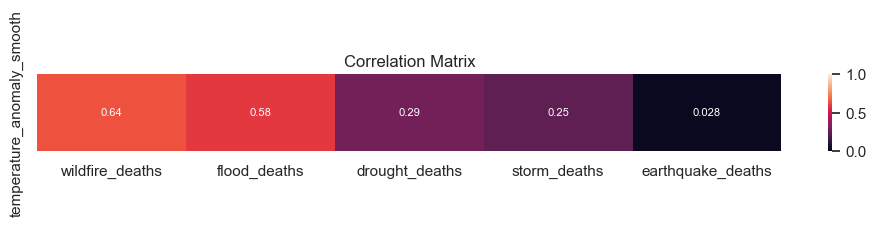

In [163]:
plotTempDisCorrelation(dis_global_yearly_deaths_wide, 'temperature_anomaly_smooth')

We find, that the correlation varies for different disaster types. As we would expect, disasters of the type Extreme temperatures have a strong correlation of 0.8 to temperature anomalies. The type Extreme temperatures does split in 3 subtypes, which we observe further in the next section.

Wildfire with a correlation of 0.64 and floods with 0.58 also are correlated with temperature anomalies.

Droughts and storm deaths are both weakly correlated, with coefficients smaller than 0.3.

Earthquakes are not correlated at all.

#### Correlation of subtypes of extreme temperature disasters with temperature anomalies

Now we will observe the correlation of subtypes of the disaster type Extreme temperature to temperature anomalies.

In [164]:
dis_type_extreme_temp = dis_all[dis_all['type'] == 'Extreme temperature ']
dis_type_extreme_temp = dis_type_extreme_temp[['year', 'subtype', 'deaths']].groupby(['year', 'subtype']).agg('sum').reset_index()
dis_type_extreme_temp_wide = pd.pivot(dis_type_extreme_temp, index='year', columns='subtype', values='deaths')
dis_type_extreme_temp_wide = reformatDisGlobalYearlyWide(dis_type_extreme_temp_wide, "_deaths")
dis_type_extreme_temp_wide = temp_global.merge(dis_type_extreme_temp_wide, how='left', on='year')
dis_type_extreme_temp_wide.fillna(0)
dis_type_extreme_temp_wide.drop('temperature_anomaly', axis=1, inplace=True)

Plot of the correlations of subtypes of disaster type Extreme temperature with smoothed temperature anomalies.

/Users/hrokitte/Documents/Uni/DOPP/A2/venv/lib/python3.10/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


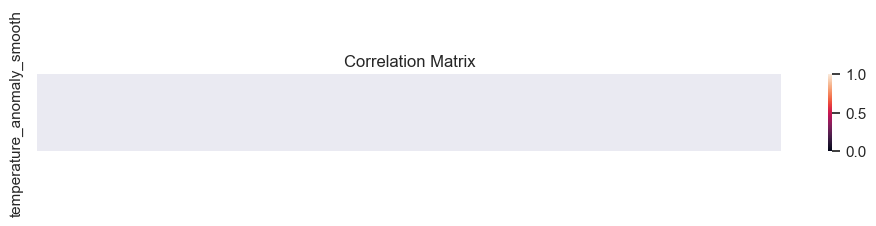

In [165]:
plotTempDisCorrelation(dis_type_extreme_temp_wide, 'temperature_anomaly_smooth')

We find, that the individual subtypes of Extreme temperature disasters are not as strongly correlated to temperature anomalies, with the highest correlation being 0.45 for the subtype heat wave deaths.

#### Correlation of disasters of type extreme temperature with temperature anomalies on a country level

In [166]:
def returnDisSubtypeTempCountry(country_code, subtype):
    dis_interesting_countries = dis_all[(dis_all['country_code']==country_code) & (dis_all['subtype']==subtype)]
    dis_country_yearly_heat_deaths = dis_interesting_countries[['year', 'subtype', 'deaths']].groupby(['year', 'subtype']).agg('sum').reset_index()
    dis_country_yearly_heat_deaths['deaths'] = dis_country_yearly_heat_deaths.deaths.astype('int32')
    dis_country_yearly_heat_deaths = temp_country[temp_country['country_code']==country_code].merge(dis_country_yearly_heat_deaths)
    dis_country_yearly_heat_deaths.fillna(0)
    return dis_country_yearly_heat_deaths[['year', 'temperature_anomaly_smooth', 'deaths']]

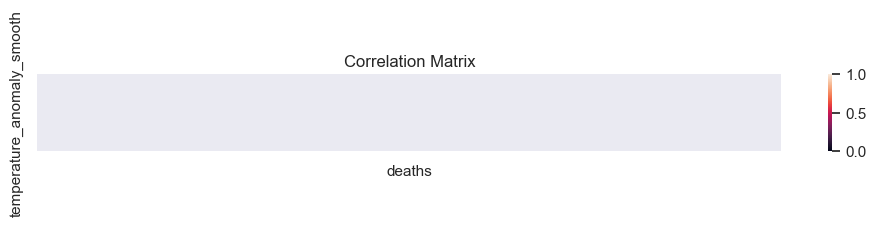

In [167]:
plotTempDisCorrelation(returnDisSubtypeTempCountry('FRA', 'Heat wave'), 'temperature_anomaly_smooth')

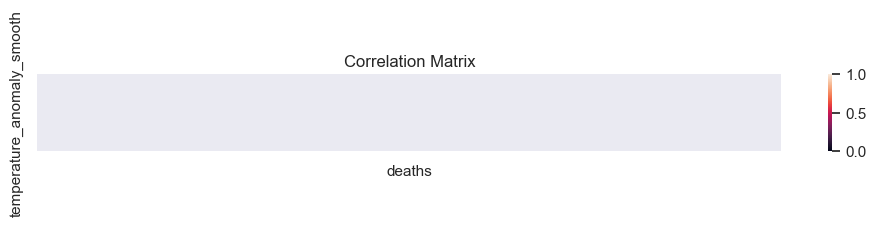

In [168]:
plotTempDisCorrelation(returnDisSubtypeTempCountry('ESP', 'Heat wave'), 'temperature_anomaly_smooth')